# Clustering for Pairs Trading 

## Table of Contents
- [1. Loading the Data](#section-1)
  * [1.1 Retrieve S&P500 Constituent Stocks (Latest)](#subsection-11)
  * [1.2 Exclude Stocks Added after December 31, 2020](#subsection-12)
  * [1.3 Retrieve Price Data From Yahoo Finance (2021 - 2023)](#subsection-13)
$$$$
- [2. Data Preparation](#section-2)
  * [2.1 Feature Engineering](#subsection-21)
  * [2.2 Z-score Normalization](#subsection-22)
  * [2.3 Anomaly Detection](#subsection-23)  
  * [2.4 Removing Outliers](#subsection-24)  
$$$$
- [3. K-Means Clustering](#section-3) 
  * [3.1 Finding the Optimal Number of Clusters : Elbow Method](#subsection-31)
  * [3.2 Cluster Visualization](#subsection-32)
$$$$
- [4. Affinity Propagation Clustering](#section-4)
  * [4.1 Finding the Optimal Number of Clusters : Damping](#subsection-42)
  * [4.2 Cluster Visualization](#subsection-42)
$$$$
- [5. Mean Shift Clustering](#section-5)
  * [5.1 Finding the Optimal Number of Clusters : Bandwidth Estimation](#subsection-51)
  * [5.2 Cluster Visualization](#subsection-52)
$$$$
- [6. Hierarchical Agglomerative Clustering](#section-6) 
  * [6.1 Finding the Optimal Number of Clusters : Linkage and Dendogram](#subsection-61)
  * [6.2 Cluster Visualization](#subsection-62)
$$$$
- [7. DBSCAN Clustering](#section-7)
  * [7.1 Finding the Optimal Number of Clusters : Nearest Neighbors Maximum Curvature Method](#subsection-71)
  * [7.2 Cluster Visualization](#subsection-72)
$$$$
- [8. Gaussian Mixture Models Clustering](#section-8)
  * [8.1 Finding the Optimal Number of Clusters : Minimum AIC and BIC](#subsection-81)
  * [8.2 Cluster Visualization](#subsection-82)
$$$$
- [9. BIRCH Clustering](#section-9)
  * [9.1 Finding the Optimal Number of Clusters : Threshold](#subsection-91)
  * [9.2 Cluster Visualization](#subsection-92)
$$$$
- [10. Clustering Performance](#section-10)
  * [10.1 Silhouette Score (>)](#subsection-101)
  * [10.2 Calinski-Harabasz Score (>)](#subsection-102)
  * [10.3 Davies-Bouldin Score (<)](#subsection-103)
$$$$
- [11. Pairs Selection](#section-11)
  * [11.1 Augmented Engle-Granger Cointegration Test](#subsection-111)
  * [11.2 Augmented Dickey Fuller Cointegration Test](#subsection-112)
  * [11.3 Johansen Cointegration Test](#subsection-113)
  * [11.4 Top Pairs : Strongly Cointegrated and Highly Correlated](#subsection-114)
  * [11.5 Pairs Visualization](#subsection-115)
$$$$
- [12. Pairs Trading](#section-12)
  * [Spread and Bollinger Bands](#subsection-121)

## Objective 

This notebook illustrates how clustering can extract more robust stock pairs for pairs trading. Testing 7 algorithms with different cluster assignment processes, we highlight their strengths and weaknesses in grouping stocks with comparable risk-return profiles. Unique methods to obtain the optimal number of clusters help explain key hyperparameters that influence within-cluster cohesion and between-cluster dispersion. 

3 cointegration tests are then conducted at the 1% significance level to extract cointegrated pairs in each cluster. Only pairs with significant cointegration in all 3 tests and whose closing prices are 85% or more correlated with each other are selected for trading. 

## Importing the Necessary Libraries 

In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 
import pykalman as pk 
from sklearn import preprocessing, model_selection, cluster, neighbors, ensemble, mixture, metrics, manifold  
from scipy.cluster import hierarchy  
from scipy.stats import norm 
from statsmodels.tsa import stattools 
from statsmodels.tsa.vector_ar import var_model, vecm 
from statsmodels.regression import linear_model  
rs = np.random.seed(123)
# pd.set_option("display.max_rows", None)  
# pd.set_option("display.max_columns", None)  
import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg") 

## Refresher on Distance Measures 

The **Euclidean distance** between two points $P = (p_1, p_2, \ldots, p_n)$ and $Q = (q_1, q_2, \ldots, q_n)$ in an $n$-dimensional space is given by:

$$ d(P, Q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2} $$

This formula calculates the square root of the sum of squared differences between each corresponding dimension of the two points. It is a measure of the straight-line distance between the points in Euclidean space.
$$$$

The **Manhattan distance** between two points $P = (p_1, p_2, \ldots, p_n)$ and $Q = (q_1, q_2, \ldots, q_n)$ in an $n$-dimensional space is given by:

$$ d(P, Q) = \sum_{i=1}^{n} |p_i - q_i| $$

This formula calculates the sum of absolute differences between each corresponding dimension of the two points. It is a measure of the distance between two points along the axes of a Cartesian coordinate system, resembling the path a person would take walking on city blocks in Manhattan.
$$$$

The **Chebyshev distance** between two vectors $\mathbf{A} = [a_1, a_2, \ldots, a_n]$ and $\mathbf{B} = [b_1, b_2, \ldots, b_n]$ in an $n$-dimensional space is given by:

$$ d(A, B) = \max_{i} |a_i - b_i| $$

Where:
- $|a_i - b_i|$ represents the absolute difference between corresponding elements of vectors $\mathbf{A}$ and $\mathbf{B}$.
- $\max_{i}$ denotes taking the maximum absolute difference across all dimensions $i$.

The Chebyshev distance measures the maximum absolute difference between corresponding elements of two vectors, providing a measure of their dissimilarity along any single dimension. 
$$$$

The **Minkowski distance** between two vectors $\mathbf{A} = [a_1, a_2, \ldots, a_n]$ and $\mathbf{B} = [b_1, b_2, \ldots, b_n]$ in an $n$-dimensional space is given by:

$$ d(A, B) = \left( \sum_{i=1}^{n} |a_i - b_i|^p \right)^{\frac{1}{p}} $$

Where:
- $p$ is a parameter that determines the "order" of the Minkowski distance. 
  - When $p = 1$, it reduces to Manhattan distance.
  - When $p = 2$, it reduces to Euclidean distance.
  - As $p$ approaches infinity, it becomes Chebyshev distance.
- $|a_i - b_i|$ represents the absolute difference between corresponding elements of vectors $\mathbf{A}$ and $\mathbf{B}$.

The Minkowski distance generalizes both Euclidean distance and Manhattan distance, providing a flexible way to measure distance in different scenarios based on the value of \( p \). It is used in various clustering and machine learning algorithms to quantify similarity or dissimilarity between data points.
$$$$

The **Cosine distance** between two vectors $\mathbf{A} = [a_1, a_2, \ldots, a_n]$ and $\mathbf{B} = [b_1, b_2, \ldots, b_n]$ is given by:

$$ d(\mathbf{A}, \mathbf{B}) = 1 - \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} $$

Where:
- $\mathbf{A} \cdot \mathbf{B}$ represents the dot product of vectors $\mathbf{A}$ and $\mathbf{B}$.
- $\|\mathbf{A}\|$ and $\|\mathbf{B}\|$ represent the Euclidean norms (lengths) of vectors $\mathbf{A}$ and $\mathbf{B}$, respectively.

The Cosine distance measures the cosine of the angle between the two vectors, indicating their similarity in direction regardless of their magnitude. 
$$$$

The **Jaccard distance** between two sets $A$ and $B$ is given by:

$$ d(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|} $$

Where:
- $|A \cap B|$ represents the cardinality (number of elements) of the intersection of sets $A$ and $B$.
- $|A \cup B|$ represents the cardinality of the union of sets $A$ and $B$.

The Jaccard distance measures dissimilarity between two sets by comparing the size of their intersection to the size of their union. 
$$$$

The **Hamming distance** between two strings $A = a_1a_2 \ldots a_n$ and $B = b_1b_2 \ldots b_n$ of equal length $n$ is given by:

$$ d(A, B) = \frac{1}{n} \sum_{i=1}^{n} \delta(a_i, b_i) $$

Where:
- $\delta(a_i, b_i)$ is the Kronecker delta function, which equals 1 if $a_i$ is different from $b_i$ and 0 otherwise.
- $n$ is the length of the strings $A$ and $B$.

The Hamming distance measures the number of positions at which corresponding elements in two strings differ. 

## 1. Loading the Data 
<a id="section-1"></a>

### 1.1 Retrieve S&P500 Constituent Stocks (Latest) 
<a id="subsection-11"></a>

In [3]:
wikipedia = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#Selected_changes_to_the_list_of_S&P_500_components")
sp500_constituents = wikipedia[0][["Symbol", "GICS Sector", "Date added"]].copy( )
sp500_constituents["Date added"] = pd.to_datetime(sp500_constituents["Date added"]) 

### 1.2 Exclude Stocks Added after December 31, 2020 
<a id="subsection-12"></a>

In [4]:
sp500_2123 = sp500_constituents.loc[sp500_constituents["Date added"] < pd.to_datetime("2020-12-31")]
sp500_2123 = sp500_2123.loc[ ~ sp500_2123["Symbol"].isin(["BF.B" , "BRK.B"]) ]
tickers_2123 = sp500_2123["Symbol"].tolist( ) 

### 1.3 Retrieve Price Data From Yahoo Finance (2021 - 2023)
<a id="subsection-13"></a>

In [5]:
start_date = "2020-12-31"
end_date = "2024-01-01"
sp500 = yf.download(tickers = tickers_2123, start = start_date, end = end_date)

[*********************100%%**********************]  450 of 450 completed


In [6]:
close = sp500["Close"].copy( ) 
returns = close.pct_change(periods = 1).iloc[1 :]
close = close.iloc[1 :]

## 2. Data Preparation 
<a id="section-2"></a>

### 2.1 Feature Engineering
<a id="subsection-21"></a>

$$
\text{Annualized } \bar{\text{Return}} = \frac{1}{T} \left( \sum_{i=t}^{T} \text{Return}_{t} \right) \times 252 
$$ 

$$
\text{Annualized } \sigma = \left( \sqrt{\frac{1}{T}\sum_{i=t}^{T}(\text{Return}_{t} - \bar{\text{Return}})^2} \right) \times \sqrt{252} 
$$ 

$$
\text{Annualized Sharpe Ratio} = \frac{\text{Annualized } \bar{\text{Return}}}{\text{Annualized } \sigma}
$$ 

In [7]:
def risk_return(returns_df) :
    """
    Arguments :
    - returns_df : DataFrame of daily returns 
    
    Returns :
    - summary_df : DataFrame displaying the annualized return, annualized standard deviation, and annualized Sharpe 
    
    Function :
    - Computes the average daily return and average daily standard deviation
    - Annualizes the average daily return and average daily standard deviation 
    """
    summary_df = returns_df.agg(["mean" , "std"]).transpose( )
    summary_df.columns = ["Return" , "Std"]

    summary_df["Annual Return"] = summary_df["Return"] * 252 
    summary_df["Annual Volatility"] =  summary_df["Std"] * np.sqrt(252)  
    summary_df["Annual Sharpe"] =  summary_df["Annual Return"].div(summary_df["Annual Volatility"])
    
    summary_df.drop(columns = ["Return", "Std"], inplace = True)
    return summary_df   

In [8]:
summary = risk_return(returns)

In [9]:
summary.round(4)

,Annual Return,Annual Volatility,Annual Sharpe
Ticker,,,
A,0.0932,0.2821,0.3302
AAL,0.0639,0.4701,0.1360
AAPL,0.1632,0.2782,0.5867
ABBV,0.1454,0.2085,0.6974
ABT,0.0278,0.2278,0.1218
...,...,...,...
XYL,0.0766,0.2739,0.2796
YUM,0.0816,0.1979,0.4122
ZBH,-0.0366,0.2546,-0.1440


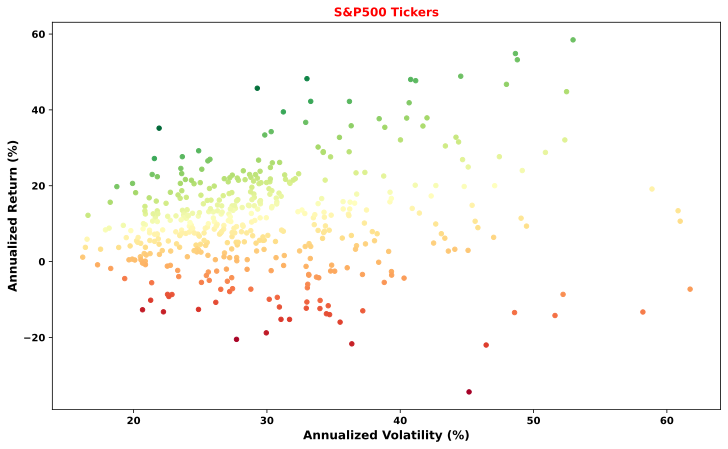

In [10]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, 
            s = 20, c = summary["Annual Sharpe"], cmap = "RdYlGn") 

plt.title(label = "S&P500 Tickers", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
# plt.colorbar(label = "Sharpe")
plt.show( )

### 2.2 Z-score Normalization 
<a id="subsection-22"></a>

$$
Z = \frac{{X - \mu}}{{\sigma}}
$$ 

In [11]:
std_scaler = preprocessing.StandardScaler( )
summary_scaled = pd.DataFrame(data = std_scaler.fit_transform(summary), index = summary.index, columns = summary.columns) 

### 2.3. Anomaly Detection
<a id="section-23"></a>

1. **Random Partitioning**
 > The algorithm starts by randomly selecting a feature and then randomly selecting a split value within the range of that feature's values.

2. **Recursive Partitioning**
> It recursively partitions the data into subsets based on random splits until each data point is isolated in its own partition.

3. **Tree Construction**
> This process creates isolation trees, which are binary trees where each internal node represents a split on a feature, and each leaf node represents an isolated data point.

4. **Path Length Calculation**
> - For each data point, the algorithm measures its average path length in the isolation trees.
> - Anomalies are expected to have shorter average path lengths because they are easier to isolate.

5. **Anomaly Score Calculation**
> - The anomaly score for each data point is calculated based on its average path length.
> - Data points with shorter average path lengths (closer to the root) are considered more likely to be anomalies.

6. **Thresholding**
> - A threshold is set to determine which data points are considered outliers based on their anomaly scores.
> - Data points with anomaly scores above the threshold are classified as outliers.

In [12]:
islf = ensemble.IsolationForest(contamination = 0.05, n_jobs = - 1, random_state = rs)
labels = islf.fit_predict(summary) 

In [13]:
anomaly_index = np.where(labels == - 1)[0]
anomaly_summary = summary.iloc[anomaly_index]

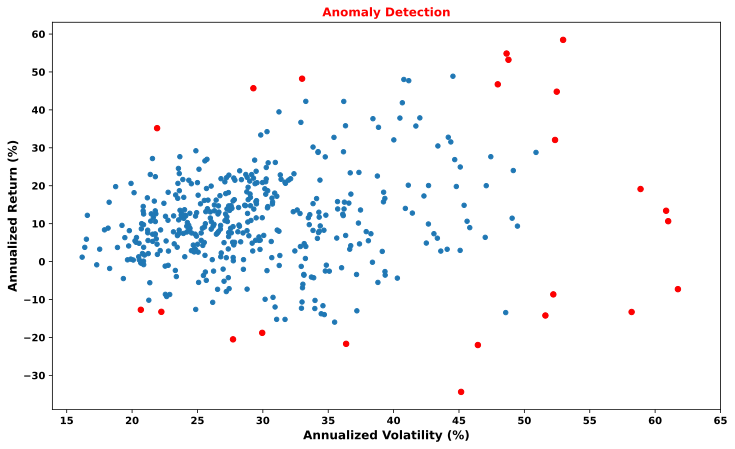

In [14]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, s = 20) 
plt.scatter(x = anomaly_summary["Annual Volatility"] * 100, y = anomaly_summary["Annual Return"] * 100, s = 30, c = "red") 

plt.xticks(ticks = range(15, 66, 5))
plt.yticks(ticks = range(- 30, 61, 10))

plt.title(label = "Anomaly Detection", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
plt.show( )

### 2.4 Removing Outliers
<a id="subsection-24"></a>

In [15]:
summary_no_outliers = summary.drop(index = anomaly_summary.index)
summary_scaled_no_outliers = summary_scaled.drop(index = anomaly_summary.index)

## 3. K-Means Clustering ***(Centroid-Based)***
<a id="section-3"></a>

1. **Initialization**
> Randomly select $ \text{\( k \)} $ centroids from the data points, where $ \text{\( k \)} $ is the number of clusters specified by the user.

2. **Assign Points to Nearest Centroid** 
> Assign each data point to the nearest centroid based on a distance measure (Euclidean distance).

3. **Update Centroids**
> Recalculate the centroid of each cluster by taking the mean of all data points assigned to that cluster.

4. **Convergence Criteria** 
> Repeat steps 2 and 3 until convergence. Convergence is achieved when centroids do not change significantly between iterations, or when a maximum number of iterations is reached.

5. **Cluster Assignment**
> Once convergence is reached, each data point is assigned to one cluster based on the nearest centroid.

6. **Output**
> The final output of the algorithm is $ \text{\( k \)} $ clusters, where each cluster is represented by its centroid and data points assigned to it.

### 3.1 Finding the Optimal Number of Clusters : Elbow Method
<a id="subsection-31"></a>

$$ \text{Inertia} = \sum_{i=0}^{n} \min_{\mu_j \in C}(||x_i - \mu_j||^2) $$

$\text{Where :}$
- $ n \text{ is the total number of samples.} $
- $ x_{i} \text{ represents each sample.} $
- $ \mu_j \text{ denotes the centroid of the cluster \( C \) to which \( x_i \) is assigned.} $
- $ ||x_i - \mu_j||^2 \text{ calculates the squared Euclidean distance between \( x_i \) and \( \mu_j \).} $

In [16]:
inertia_vals = [ ]
silhouette_vals = [ ]
for k in range(2, 16) :
    
    kmeans_clt = cluster.KMeans(n_clusters = k, init = "k-means++" , n_init = 10, random_state = rs)
    kmeans_clt.fit(summary_scaled_no_outliers) 
    inertia_vals.append(kmeans_clt.inertia_) 
    
    silhouette = metrics.silhouette_score(summary_scaled_no_outliers, kmeans_clt.labels_, metric = "euclidean")
    silhouette_vals.append(silhouette)  
    
inertia_df = pd.DataFrame({"N_Clusters" : range(2, 16), "Inertia" : inertia_vals})

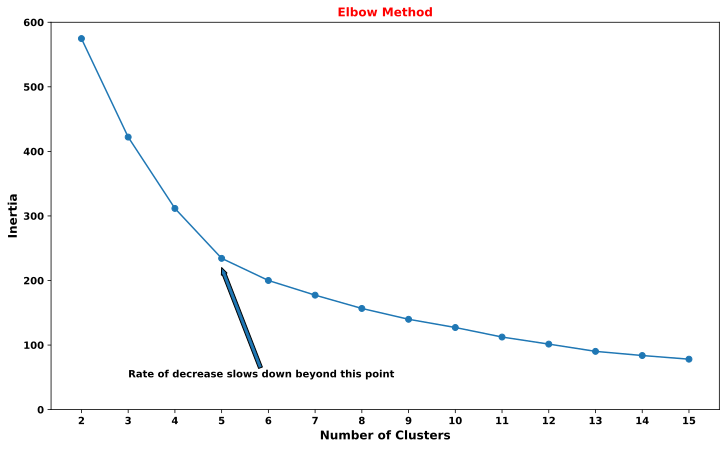

In [17]:
plt.figure(figsize = (12, 7))
plt.plot(inertia_df["N_Clusters"], inertia_df["Inertia"], marker = "o") 
plt.annotate("Rate of decrease slows down beyond this point", 
             xy = (5, 220), xytext = (3, 50), arrowprops = {"width" : 4, "headwidth" : 6, "headlength" : 7}) 

plt.title(label = "Elbow Method", c = "red")
plt.xticks(ticks = range(2, 16)) 
plt.yticks(ticks = range(0, 601, 100)) 
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel(ylabel = "Inertia", fontsize = 12)
plt.style.use("default")
plt.show( )

In [18]:
n_clusters = 5   
kmeans_clt = cluster.KMeans(n_clusters = n_clusters, init = "k-means++" , n_init = 10, random_state = rs)
kmeans_clt.fit(summary_scaled_no_outliers) 

KMeans(n_clusters=5, n_init=10)

In [19]:
kmeans_clt_labels = kmeans_clt.predict(summary_scaled_no_outliers)  
kmeans_clt_df = pd.DataFrame({"Cluster" : kmeans_clt_labels}, index = summary_scaled_no_outliers.index) 
kmeans_centroids = std_scaler.inverse_transform(kmeans_clt.cluster_centers_)

### 3.2 Cluster Visualization 
<a id="subsection-32"></a>

In [20]:
def plot_clusters(clt_type, X_unscaled, clt_labels, clt_centroids = None) :
    """
    Arguments :
    - clt_type : str for the clustering algorithm 
    - X_unscaled : DataFrame of annualized return, annualized volatility, and annualized sharpe prior to standardization 
    - clt_labels : ndarray containing the cluster label of each observation  
    - clt_centroids : ndarray containing the cluster centroids (if available)
    
    Returns :
    - None
    
    Function :
    - Plots scatter points 
    """
    plt.figure(figsize = (12, 7))
    plt.scatter(x = X_unscaled["Annual Volatility"].mul(100), y = X_unscaled["Annual Return"].mul(100), 
                s = 20, c = clt_labels, cmap = "gist_rainbow")
    if clt_centroids is not None :
        plt.plot(clt_centroids[: , 1] * 100, clt_centroids[: , 0] * 100, "Pk", markersize = 9, label = "cluster centroids")
        plt.legend( )
    
    plt.xticks(ticks = range(15, 66, 5))
    plt.yticks(ticks = range(- 30, 61, 10))

    plt.title(label = f"{clt_type} Clustering", c = "red")
    plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
    plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
    # plt.colorbar(ticks = range(0, n_clusters), label = "Cluster")
    plt.show( )

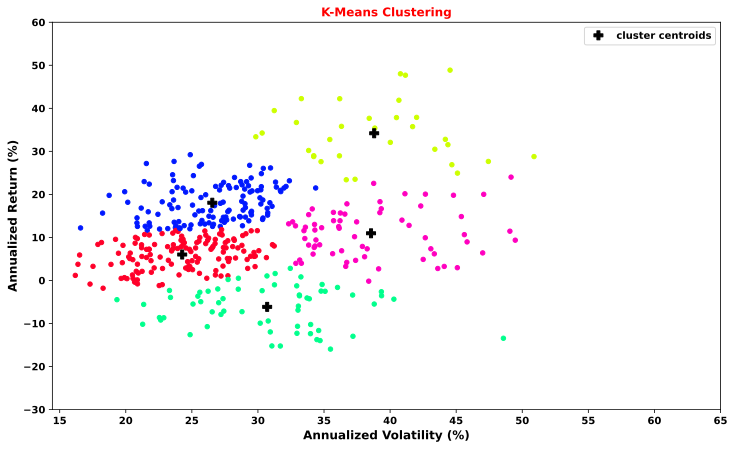

In [21]:
plot_clusters("K-Means", summary_no_outliers, kmeans_clt_labels, kmeans_centroids)

In [22]:
def plot_clusters_count(clt_type, clt_labels) :
    """
    Arguments :
    - clt_type : str for the clustering algorithm 
    - clt_labels : ndarray containing the cluster label of each sample 
    
    Returns :
    - None
    
    Function :
    - Plots a horizontal bar chart showing the number of observations in each cluster 
    """
    n_clusters = len(np.unique(clt_labels))
    clt_count = pd.Series(clt_labels).value_counts(ascending = True)
    
    if n_clusters % 2 == 0 :
        height = int(n_clusters / 2)
    else :
        height = int(n_clusters / 2) + 1
    clt_count.plot(kind = "barh", figsize = (12, height), fontsize = 10) 
    
    plt.title(label = f"{clt_type} Clustering", c = "red")
    plt.xlabel("Number of Tickers", fontsize = 12)
    plt.ylabel("Cluster", fontsize = 12)
    plt.show( )

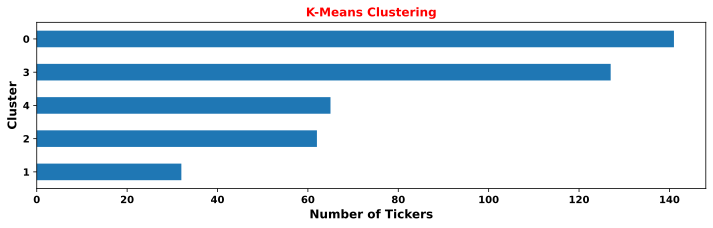

In [23]:
plot_clusters_count("K-Means", kmeans_clt_labels)

In [24]:
def plot_clusters_silh(clt_type, X_fit, clt_labels) :
    """
    Arguments :
    - clt_type : str for the clustering algorithm 
    - X_fit : DataFrame on which the clustering algorithm is fitted  
    - clt_labels : ndarray containing the cluster label for each sample 
    
    Returns :
    - None
    
    Function :
    - Plots the silhouette score of all samples in each cluster 
    """
    n_clusters = len(np.unique(clt_labels))
    fig , ax = plt.subplots(figsize = (12, n_clusters * 1), sharex = False, sharey = False, nrows = 1, ncols = 1)
    ax.set_ylim([0, len(X_fit) + (n_clusters + 1) * 10])

    silh_avg = metrics.silhouette_score(X_fit, clt_labels)
    samples_silh_values = metrics.silhouette_samples(X_fit, clt_labels)

    y_lower = 10
    for i in range(n_clusters) :

        clt_silh_values = samples_silh_values[clt_labels == i]
        clt_silh_values.sort( )

        clt_size = clt_silh_values.shape[0]
        y_upper = y_lower + clt_size
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, clt_silh_values, facecolor = color, edgecolor = color, alpha = 0.7)

        ax.text(-0.05, y_lower + 0.5 * clt_size, str(i))

        y_lower = y_upper + 10  

    ax.set_title(f"{clt_type} Clustering", c = "red")
    ax.set_xlabel("Silhouette Score", fontsize = 12)
    ax.set_ylabel("Cluster", fontsize = 12)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x = silh_avg, color = "red", linestyle = "--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.show( )

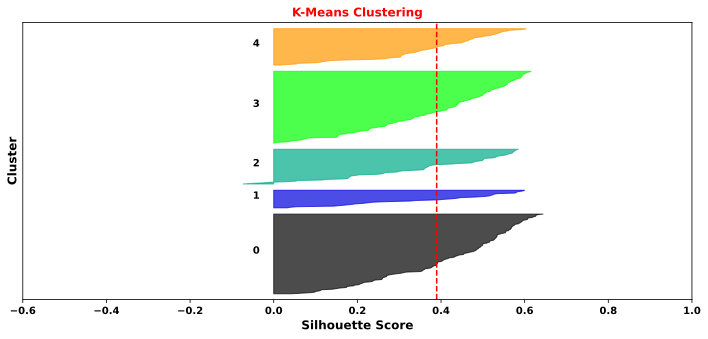

In [25]:
plot_clusters_silh("K-Means", summary_scaled_no_outliers, kmeans_clt_labels)

## 4. Affinity Propagation Clustering ***(Centroid-Based)***
<a id="section-4"></a>

1. **Similarity Matrix Calculation**
> The similarity matrix quantifies the similarity between pairs of data points based on a distance measure (negative squared Euclidean).

2. **Preference Initialization**
> Assign each data point a preference value, which indicates the initial level of attractiveness for a data point to become an exemplar. Larger values correspond to higher likelihood of becoming an exemplar. Preference controls the number of exemplars used. 
$$ p(i) = \text{median(similarity_matrix(i,:))} $$

3. **Message Passing**
> - Iteratively update 2 messages for each data point $i$
>> - **Responsibility (r)**: Indicates how well-suited $i$ is as the exemplar for another data point $k$.
>> $$ R(i, k) = S(i, k) - \max_{k' \neq k} (A(i, k') + S(i, k')) $$
$$$$
>> - **Availability (a)**: Indicates the suitability of a data point $k$ choosing another data point as its exemplar over $i$.
>> $$ A(i, k) = \min \left(0, R(k, k) + \sum_{i' \neq i, i' \neq k} \max(0, R(i', k)) \right) $$
$$$$
> - Introduce a damping factor during updates to prevent oscillations 
>> $$ R_{t+1}(i, k) = (1 - \lambda) \times R_{t+1}(i, k) + \lambda \times R_{t}(i, k) $$
$$$$
>> $$ A_{t+1}(i, k) = (1 - \lambda) \times A_{t+1}(i, k) + \lambda \times A_{t}(i, k) $$

4. **Exemplar Selection**
> At each iteration, evaluate each data point's suitability as exemplars based on the received messages. Data points with the highest responsibility and lowest availabily scores are chosen as exemplars.

5. **Cluster Assignment**
> At each iteration, assign each data point to the closest exemplar (with which it has the highest similarity).

6. **Convergence Criteria**
> Repeat steps 3-5 until convergence criteria are met. Convergence may be reached when the assignment of data points to exemplars no longer change significantly between iterations, or when a maximum number of iterations is reached.

7. **Output**
> The final output of the algorithm is the clusters formed, where each cluster is represented by its exemplar and data points assigned to it. 

### 4.1 Finding the Optimal Number of Clusters : Damping 
<a id="subsection-41"></a>

In [26]:
affpg_clt = cluster.AffinityPropagation(damping = 0.8, max_iter = 1000, affinity = "euclidean", random_state = rs)
affpg_clt.fit(summary_scaled) 

AffinityPropagation(damping=0.8, max_iter=1000)

In [27]:
affpg_clt_labels = affpg_clt.predict(summary_scaled)  
affpg_clt_df = pd.DataFrame({"Cluster" : affpg_clt_labels}, index = summary_scaled.index) 
affpg_centroids = std_scaler.inverse_transform(affpg_clt.cluster_centers_)

In [28]:
n_clusters = len(np.unique(affpg_clt_labels))

### 4.2 Cluster Visualization 
<a id="subsection-42"></a>

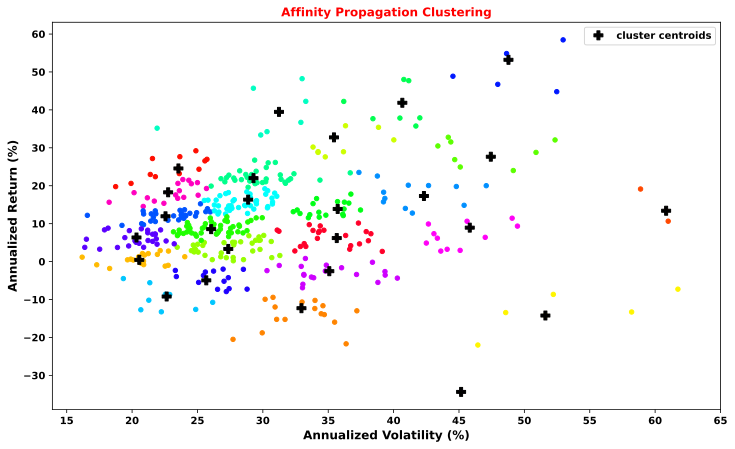

In [29]:
plot_clusters("Affinity Propagation", summary, affpg_clt_labels, affpg_centroids)

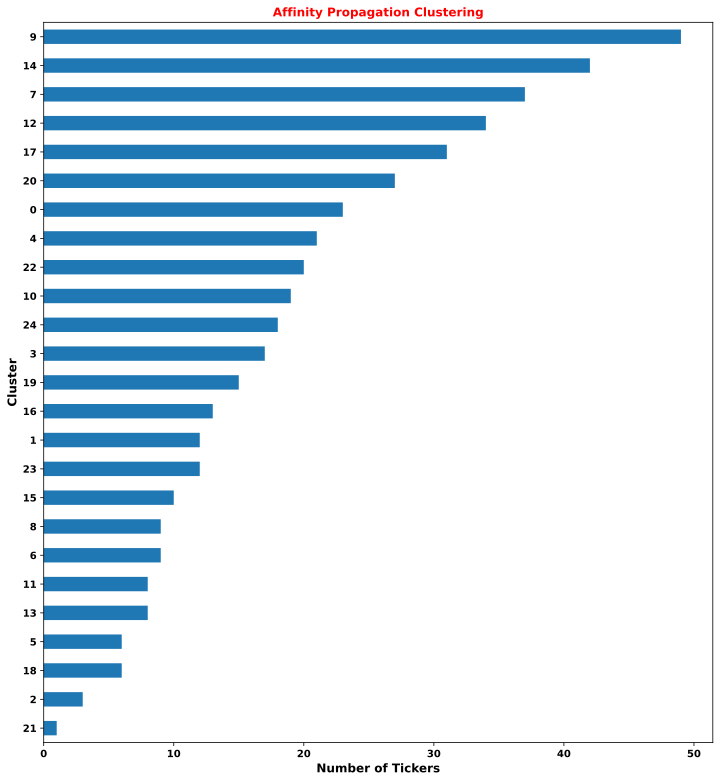

In [30]:
plot_clusters_count("Affinity Propagation", affpg_clt_labels)

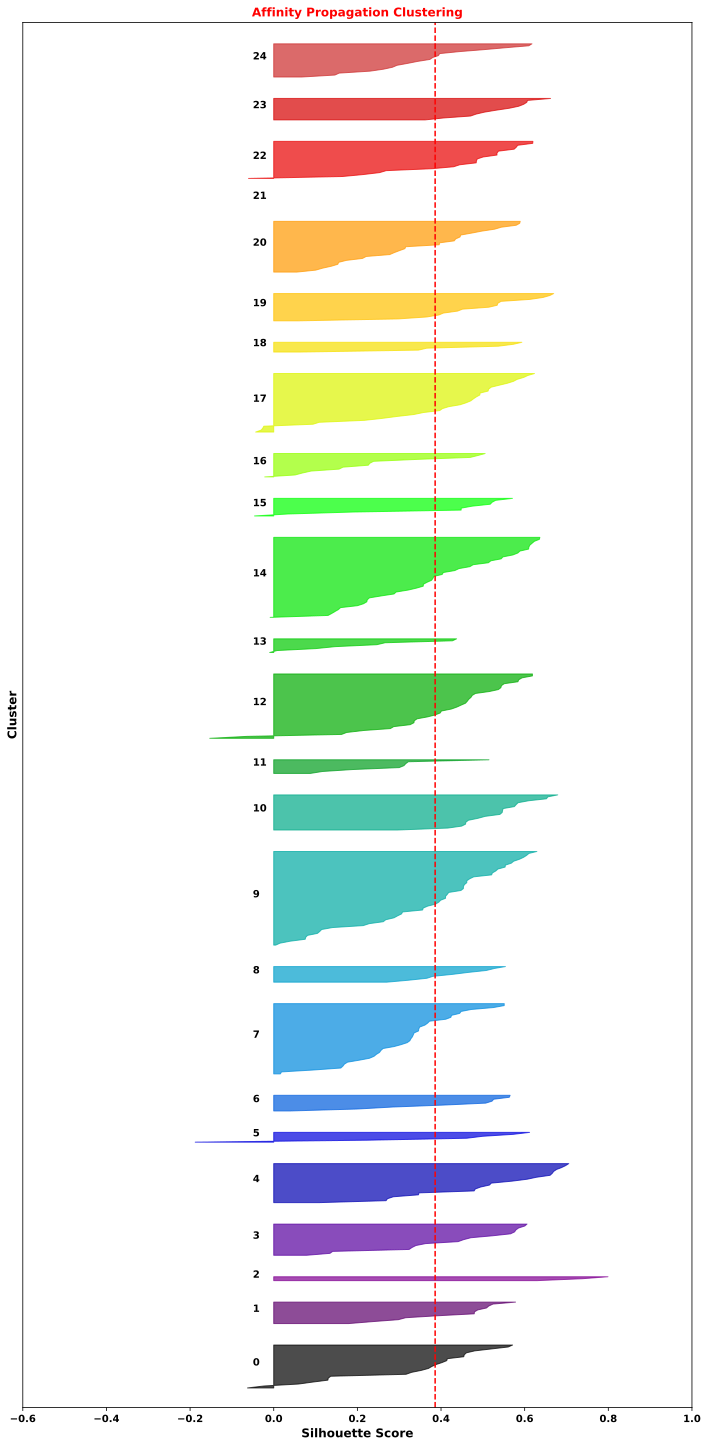

In [31]:
plot_clusters_silh("Affinity Propagation", summary_scaled, affpg_clt_labels)

## 5. Mean Shift Clustering ***(Centroid-Based)***
<a id="section-5"></a>

1. **Bandwidth Selection**
> Specify the size of the window around a data point, also known as its neighborhood. Points within the window are considered neighbors. 

2. **Initialization**
> Start by selecting a random point as the initial cluster centroid. 

3. **Local Density Point Calculation**
> Compute the weighted mean of points in the neighborhood. 

4. **Centroid Update**
> Set the local density point as the new centroid. Compute the window of the new centroid. Neighborhood will contain new points. 

5. **Convergence Criteria** 
> Repeat steps 2, 3, and 4 until the centroid and its window does not update anymore. Local density maximum has been reached. This is considered the `densest point`. Repeat step 5 for each remaining data point. 

6. **Cluster Assignment**
> Data points that converge towards the same local density maximum belong to the same cluster.

7. **Output**
> The final output of the algorithm is the clusters formed, where each cluster is represented by its mode and data points assigned to it.

### 5.1 Finding the Optimal Number of Clusters : Bandwidth Estimation 
<a id="subsection-51"></a>

In [32]:
bandwidth = cluster.estimate_bandwidth(summary_scaled, quantile = 0.04, n_jobs = -1, random_state = rs)
mnsft_clt = cluster.MeanShift(bandwidth = bandwidth, n_jobs = - 1)
mnsft_clt.fit(summary_scaled) 

MeanShift(bandwidth=0.571478388889222, n_jobs=-1)

In [33]:
mnsft_clt_labels = mnsft_clt.predict(summary_scaled)  
mnsft_clt_df = pd.DataFrame({"Cluster" : mnsft_clt_labels}, index = summary_scaled.index) 
mnsft_centroids = std_scaler.inverse_transform(mnsft_clt.cluster_centers_)  

In [34]:
n_clusters = len(np.unique(mnsft_clt_labels))

### 5.2 Cluster Visualization 
<a id="subsection-52"></a>

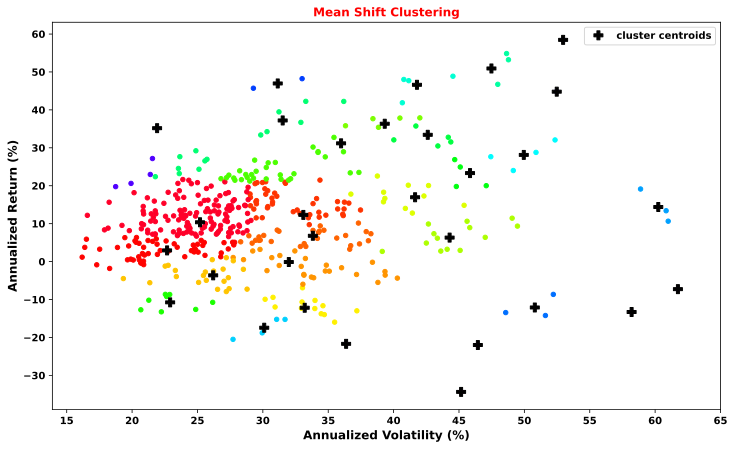

In [35]:
plot_clusters("Mean Shift", summary, mnsft_clt_labels, mnsft_centroids)

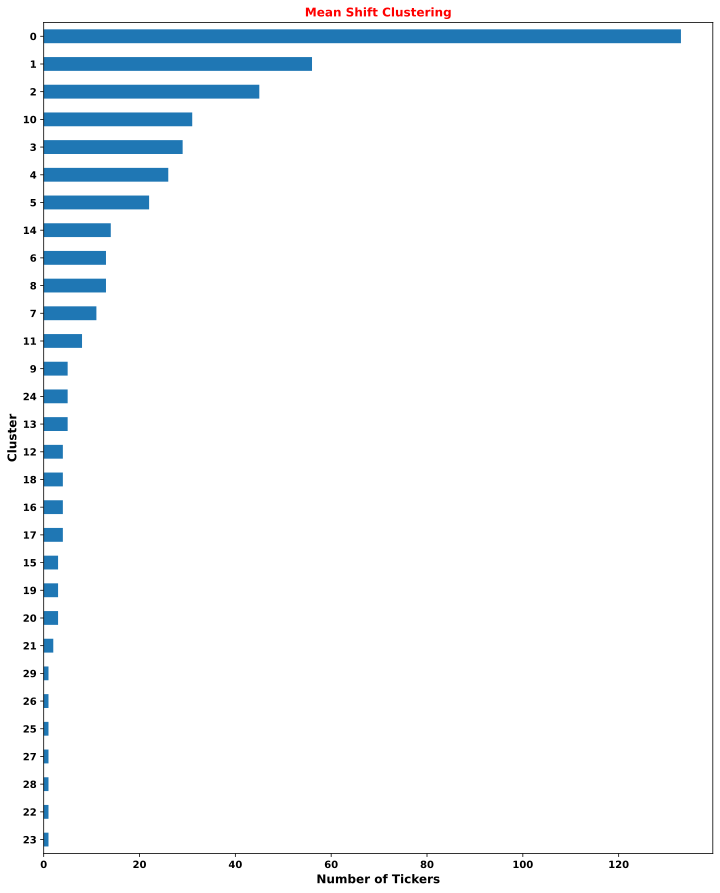

In [36]:
plot_clusters_count("Mean Shift", mnsft_clt_labels)

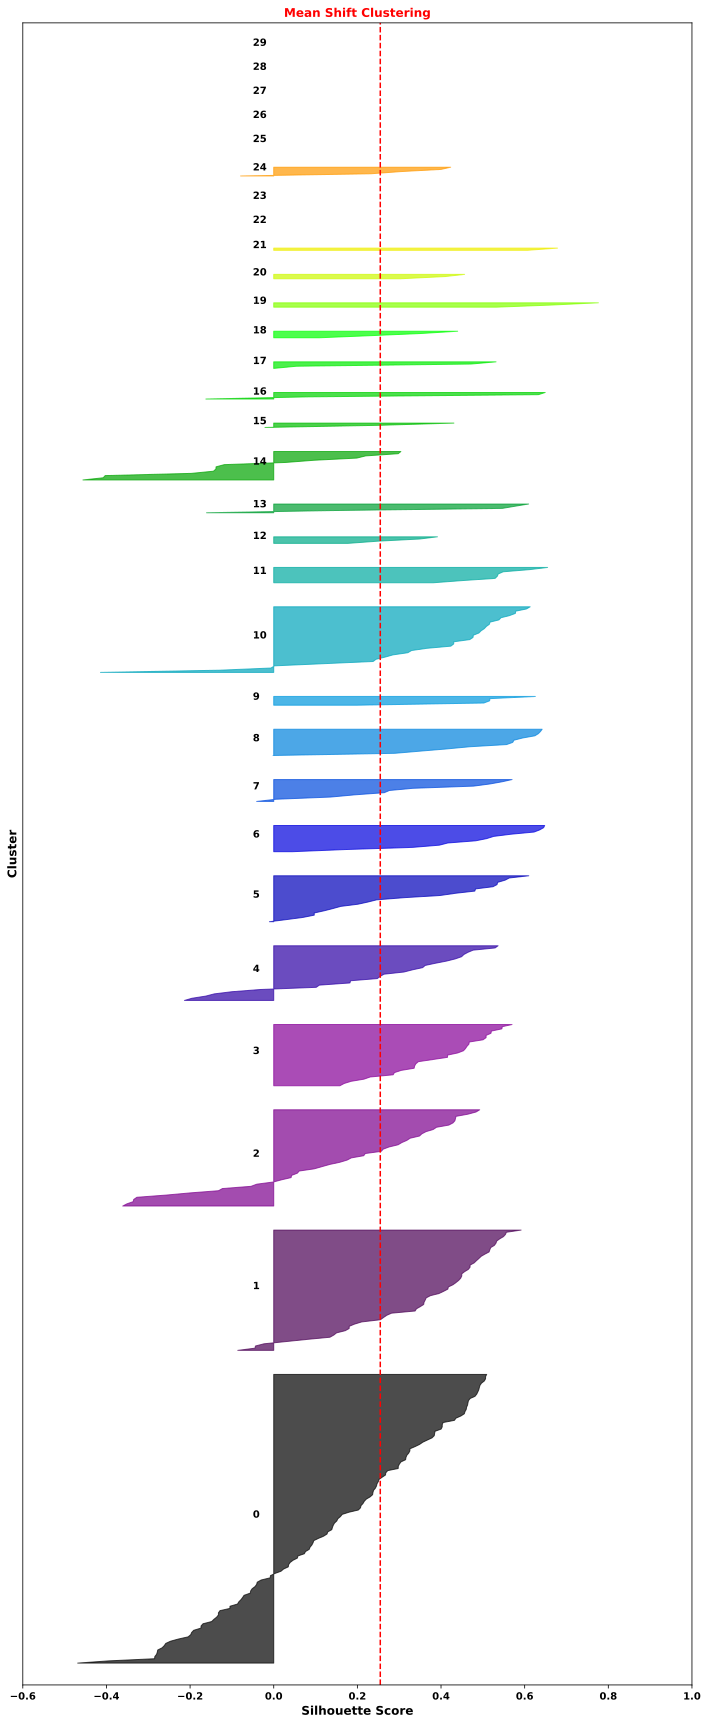

In [37]:
plot_clusters_silh("Mean Shift", summary_scaled, mnsft_clt_labels)

## 6. Hierarchical Agglomerative Clustering ***(Connectivity-Based)***
<a id="section-6"></a>

1. **Initialization**
> Start by considering each data point as a separate cluster.

2. **Pairwise Distance Calculation**
> Compute the pairwise distance (or dissimilarity) between each pair of clusters. This can be done using various distance metrics such as Euclidean distance, Manhattan distance, or cosine distance.
>> - **Single Linkage**: distance between closest points 
>> - **Complete Linkage**: distance between furthest points 
>> - **Average Linkage**: average distance between all pairs of points 
>> - **Ward's Linkage**: minimize variance of the merged clusters 

3. **Merge Clusters**
> Identify the two closest clusters based on the computed pairwise distances and merge them into a single cluster. This step is repeated iteratively until only a single cluster remains.

4. **Dendrogram Construction**
> Construct a dendrogram to visualize the hierarchical clustering process. The dendrogram shows the order in which clusters are merged and the distance at which each merge occurs.

5. **Cluster Assignment**
> Decide the number of clusters by cutting the dendrogram at a desired distance threshold. Each branch of the dendrogram below the cut represents a separate cluster.

6. **Output**
> The final output of the algorithm is the clusters formed at the chosen cut-off level of the dendrogram, and data points assigned to it.

### 6.1 Finding the Optimal Number of Clusters : Linkage and Dendogram
<a id="subsection-61"></a>

In [38]:
linkage = hierarchy.linkage(summary_scaled, method = "ward")

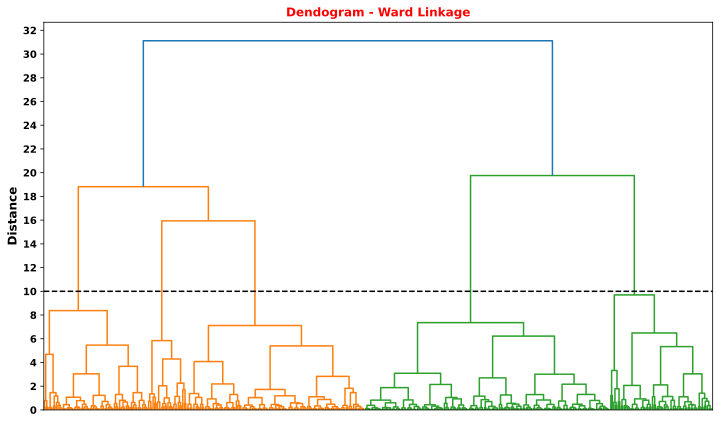

In [39]:
plt.figure(figsize = (12, 7))
hierarchy.dendrogram(linkage, no_labels = True)
plt.axhline(y = 10, linestyle = "--", c = "black")

plt.title(label = "Dendogram - Ward Linkage", c = "red")
plt.yticks(ticks = range(0, 33, 2))
plt.ylabel(ylabel = "Distance", fontsize = 12)
plt.show( )

In [40]:
distance = 10 
clusters = hierarchy.fcluster(linkage, distance, criterion = "distance")

In [41]:
n_clusters = len(np.unique(clusters)) 
hagg_clt = cluster.AgglomerativeClustering(n_clusters = n_clusters, linkage = "ward", metric = "euclidean") 

In [42]:
hagg_clt_labels = hagg_clt.fit_predict(summary_scaled) 
hagg_clt_df = pd.DataFrame({"Cluster" : hagg_clt_labels}, index = summary_scaled.index) 

### 6.2 Cluster Visualization 
<a id="subsection-62"></a>

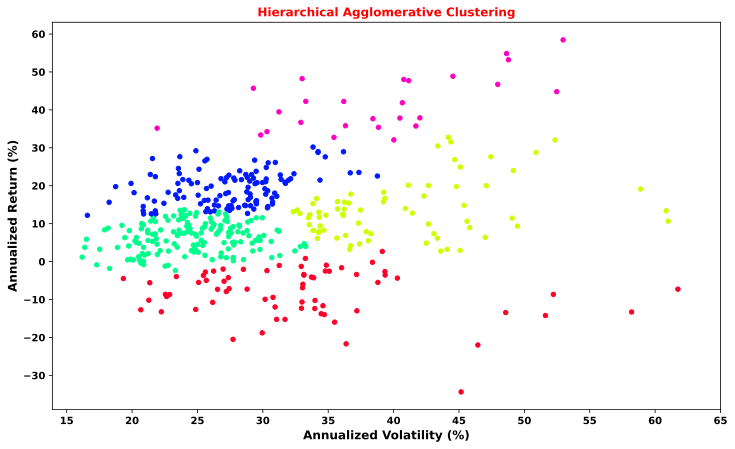

In [43]:
plot_clusters("Hierarchical Agglomerative", summary, hagg_clt_labels)

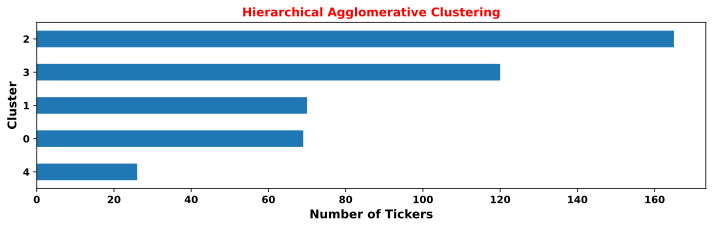

In [44]:
plot_clusters_count("Hierarchical Agglomerative", hagg_clt_labels)

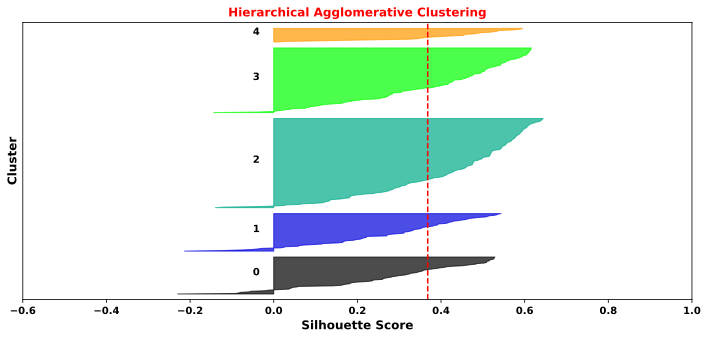

In [45]:
plot_clusters_silh("Hierarchical Agglomerative", summary_scaled, hagg_clt_labels)

## 7. DBSCAN Clustering ***(Density-Based)***
<a id="section-7"></a>

1. **Initialization**
> Specify two key parameters for DBSCAN :
> - **Epsilon ($\varepsilon$)**: The maximum distance between two samples for them to be considered as in the same neighborhood.
> - **MinPts**: The minimum number of samples in a neighborhood for a data point to be considered as a core point.

2. **Core Point and Border Point Identification**
> - A core point is a data point that has at least MinPts data points (including itself) within its $\varepsilon$ -neighborhood.
> - A border point is a data point that is part of a core point's neighborhood but does not have enough neighbors to be a core point.

3. **Cluster Expansion**
> Expand clusters from core points. For each core point :
> - Form a new cluster if it has not been assigned to any cluster yet.
> - Recursively add all reachable points (density-reachable) to the cluster if they are core points themselves.

4. **Noise Point Identification**
> Nose points are data points that are not core points and are not density-reachable from any core points.

5. **Output**
> The final output of the algorithm is the clusters formed, where each cluster contains all data points that are density-connected. Additionally, noise points may be labeled separately or discarded depending on the application.

### 7.1 Finding the Optimal Number of Clusters : Nearest Neighbor Maximum Curvature Method 
<a id="subsection-71"></a>

In [46]:
nn = neighbors.NearestNeighbors(n_neighbors = 2)
nn.fit(summary_scaled)

NearestNeighbors(n_neighbors=2)

In [47]:
distances, indices = nn.kneighbors(summary_scaled) 
distances = np.sort(distances, axis = 0)[: , 1]

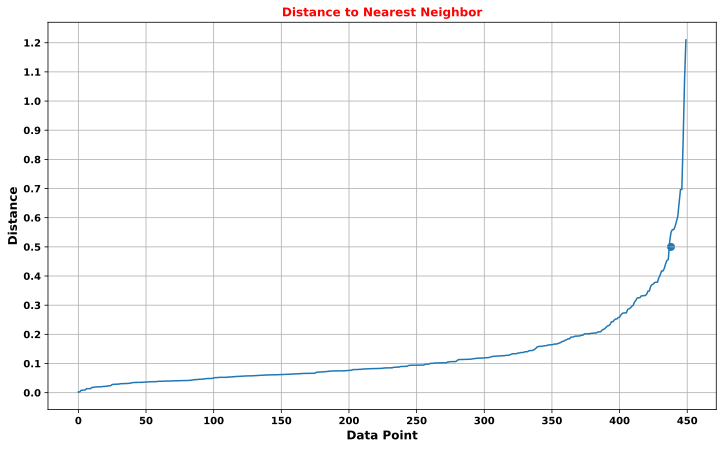

In [48]:
plt.figure(figsize = (12, 7))
plt.plot(distances)  
plt.scatter(438, 0.5, s = 50)

plt.title(label = "Distance to Nearest Neighbor", c = "red")
plt.xticks(ticks = range(0, 451, 50))
plt.yticks(ticks = np.array(range(0, 121, 10)) / 100)
plt.xlabel(xlabel = "Data Point", fontsize = 12)
plt.ylabel(ylabel = "Distance", fontsize = 12)
plt.grid( )
plt.show( ) 

In [49]:
dbscan_clt = cluster.DBSCAN(eps = 0.5, min_samples = 3, metric = "euclidean", n_jobs = - 1) 

In [50]:
dbscan_clt_labels = dbscan_clt.fit_predict(summary_scaled)  
dbscan_clt_df = pd.DataFrame({"Cluster" : dbscan_clt_labels}, index = summary_scaled.index) 

In [51]:
n_clusters = len(np.unique(dbscan_clt_labels)) 

### 7.2 Cluster Visualization 
<a id="subsection-72"></a>

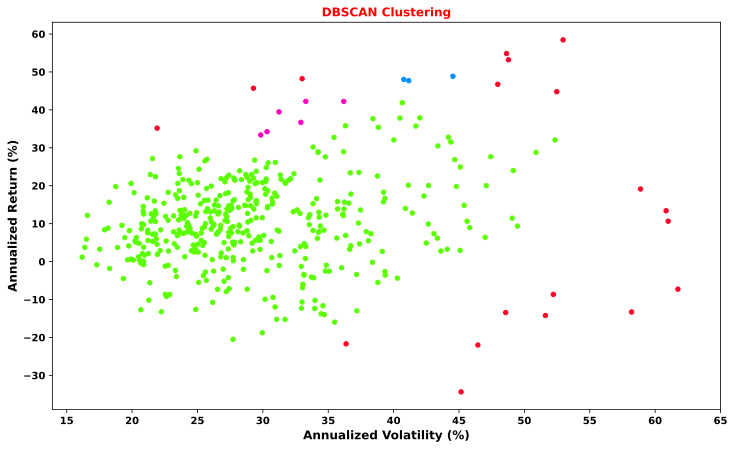

In [52]:
plot_clusters("DBSCAN", summary, dbscan_clt_labels)

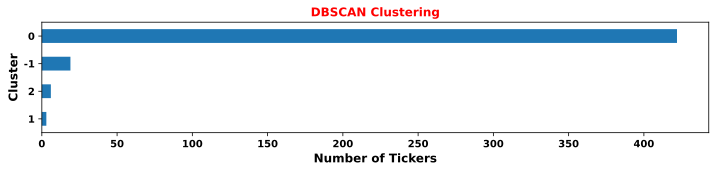

In [53]:
plot_clusters_count("DBSCAN", dbscan_clt_labels)

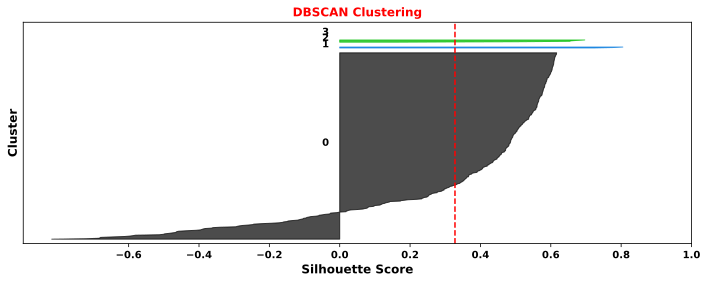

In [54]:
plot_clusters_silh("DBSCAN", summary_scaled, dbscan_clt_labels)

## 8. Gaussian Mixture Models Clustering ***(Distribution-Based)*** 
<a id="section-8"></a>

1. **Initialization**
> - Specify the number of clusters $ \text{\( k \)} $ that you want the model to identify.
> - Initialize the parameters of the $ \text{\( k \)} $ Gaussian distributions : 
>> - **Mean** :  $ \mu_1, \mu_2, \ldots, \mu_k $
>> - **Covariance matrices** :  $ \sigma_1, \sigma_2, \ldots, \sigma_k $
>> - **Mixing coefficients** : $ \pi_1, \pi_2, \ldots, \pi_k $

2. **Expectation-Maximization (EM)** 
> - **Expectation**
>> - Compute the probability that each data point belongs $x_i$ to each cluster $j$ using current parameter estimates. This is done using Bayes' theorem and the probability density function of multivariate Gaussian distributions.
$$ P(Z = j | X = x_i) = \frac{\pi_j \cdot \mathcal{N}(x_i | \mu_j, \Sigma_j)}{\sum_{l=1}^{k} \pi_l \cdot \mathcal{N}(x_i | \mu_l, \Sigma_l)} $$
>> - Update the `responsibility` matrix, which stores these probabilities.
> - **Maximization**
>> - Update the parameters of each Gaussian distribution using the current responsibilities.
>> - The mean is updated as the weighted average of data points, where the weights are the responsibilities. 
$$ \mu_j = \frac{\sum_{i=1}^{N} P(Z = j | X = x_i) \cdot x_i}{\sum_{i=1}^{N} P(Z = j | X = x_i)} $$
>> - The covariance matrix is updated using the weighted sum of the outer products of data points minus the updated mean, weighted by responsibilities. 
$$ \sigma_j = \frac{\sum_{i=1}^{N} P(Z = j | X = x_i) \cdot (x_i - \mu_j) \cdot (x_i - \mu_j)^T}{\sum_{i=1}^{N} P(Z = j | X = x_i)} $$
>> - The mixing coefficient is updated as the mean responsibility of data points assigned to each cluster.
$$ \pi_j = \frac{\sum_{i=1}^{N} P(Z = j | X = x_i)}{N} $$

3. **Convergence Criteria** 
> Convergence may be reached when the change in log-likelihood or the change in parameters between iterations falls below a specified threshold, or when a maximum number of iterations is reached. 

4. **Cluster Assignment**
> After convergence, each data point is assigned to the cluster with the highest probability (i.e., the cluster with the highest responsibility). 

5. **Final Output**
> The final output of the algorithm is the $ \text{\( k \)} $ clusters formed, where each cluster is represented by its centroid and data points assigned to it. 

### 8.1 Finding the Optimal Number of Clusters : Minimum AIC and BIC
<a id="subsection-81"></a>

In [55]:
aic_list = [  ]
bic_list = [  ]
for n_clusters in range(2, 26) :
    
    gmm_clt = mixture.GaussianMixture(n_components = n_clusters, covariance_type = "full", random_state = rs)
    gmm_clt.fit(summary_scaled_no_outliers)     
    
    aic = gmm_clt.aic(summary_scaled_no_outliers)
    bic = gmm_clt.bic(summary_scaled_no_outliers)
    aic_list.append(aic)
    bic_list.append(bic)
    
inf_criterion_df = pd.DataFrame({"N_Clusters" : range(2, 26), "AIC" : aic_list, "BIC" : bic_list})

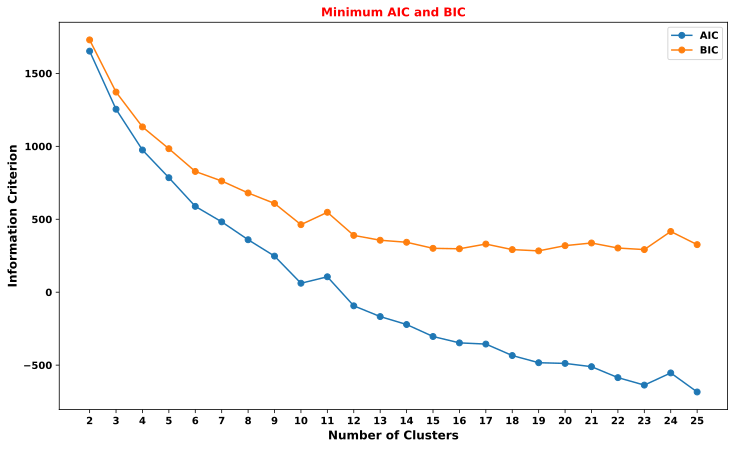

In [56]:
plt.figure(figsize = (12, 7))
plt.plot(inf_criterion_df["N_Clusters"], inf_criterion_df[["AIC", "BIC"]], marker = "o", label = ["AIC", "BIC"]) 

plt.title(label = "Minimum AIC and BIC", c = "red")
plt.xticks(ticks = range(2, 26)) 
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel(ylabel = "Information Criterion", fontsize = 12)
plt.legend( )
plt.style.use("default")
plt.show( )

In [57]:
n_clusters = 25  
gmm_clt = mixture.GaussianMixture(n_components = n_clusters, covariance_type = "full", random_state = rs)
gmm_clt.fit(summary_scaled_no_outliers) 

GaussianMixture(n_components=25)

In [58]:
gmm_clt_labels = gmm_clt.predict(summary_scaled_no_outliers)  
gmm_clt_df = pd.DataFrame({"Cluster" : gmm_clt_labels}, index = summary_scaled_no_outliers.index) 
gmm_centroids = std_scaler.inverse_transform(gmm_clt.means_) 

### 8.2 Cluster Visualization 
<a id="subsection-82"></a>

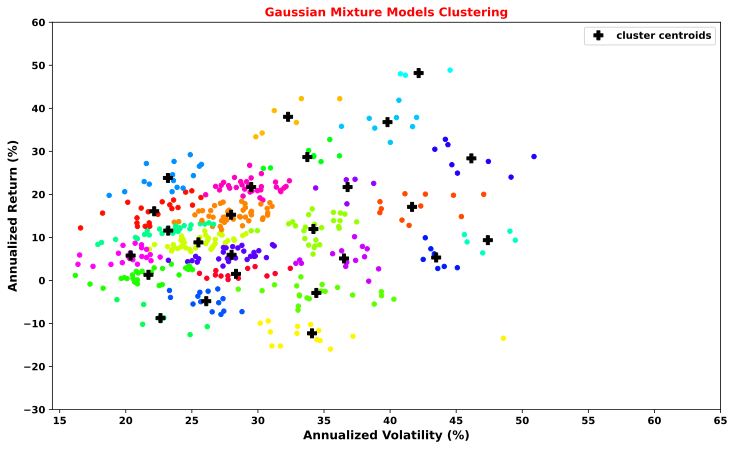

In [59]:
plot_clusters("Gaussian Mixture Models", summary_no_outliers, gmm_clt_labels, gmm_centroids)

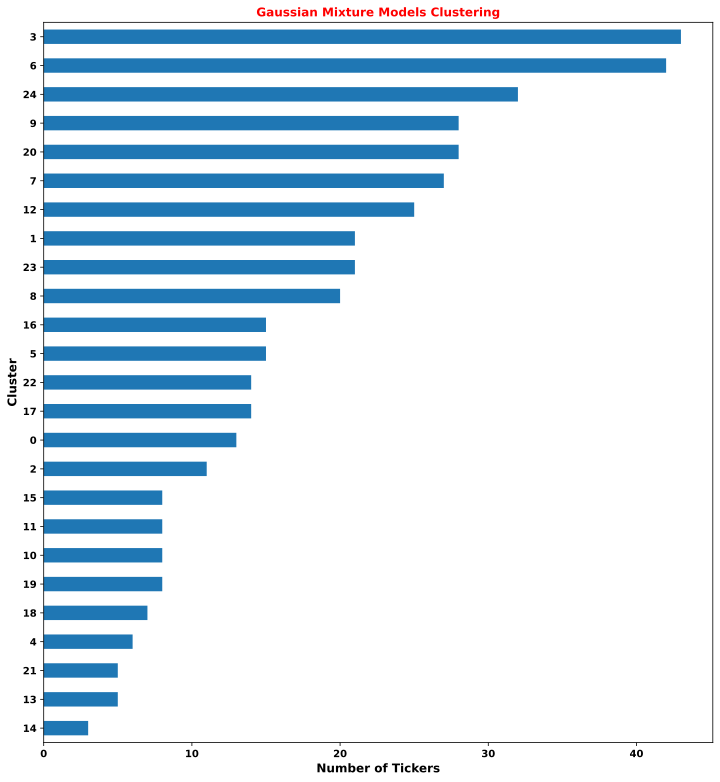

In [60]:
plot_clusters_count("Gaussian Mixture Models", gmm_clt_labels)

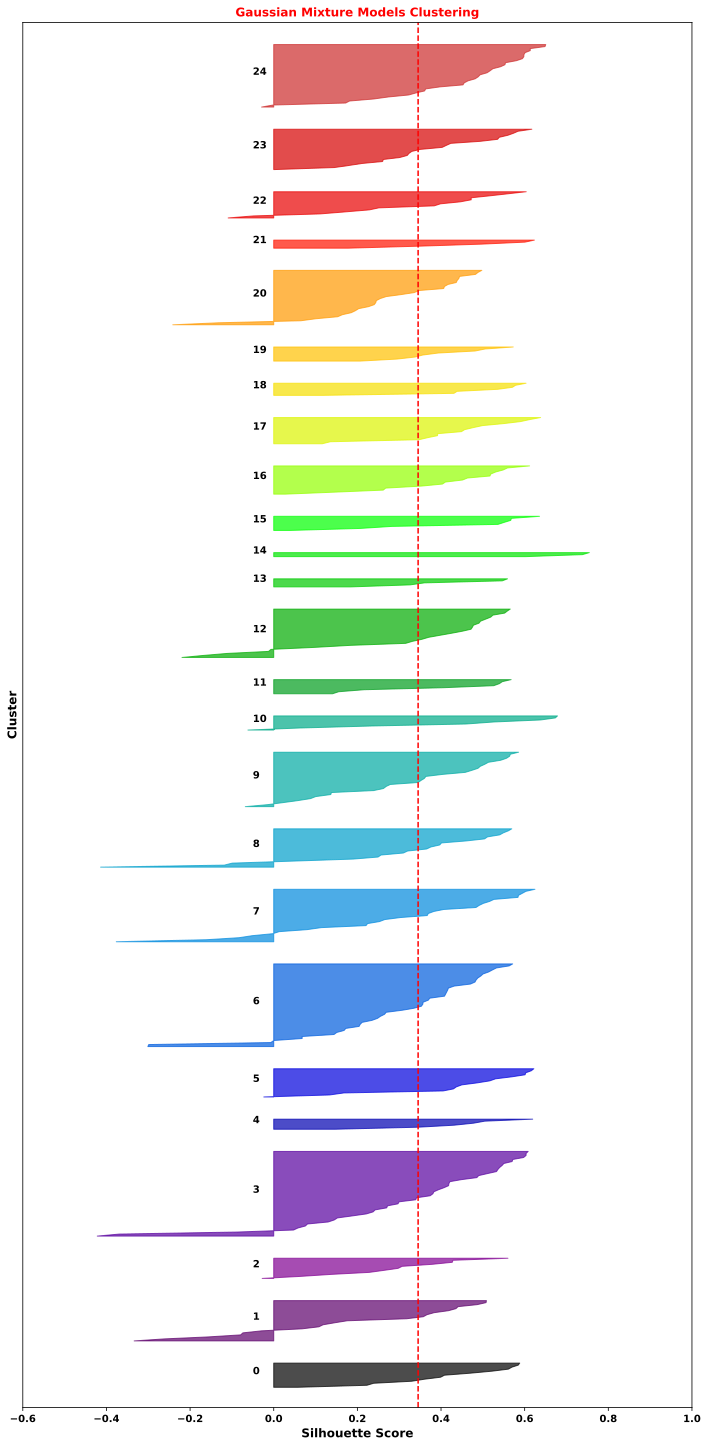

In [61]:
plot_clusters_silh("Gaussian Mixture Models", summary_scaled_no_outliers, gmm_clt_labels)

## 9. BIRCH Clustering ***(Compression-Based)*** 
<a id="section-9"></a>

1. **Initialization**
> - Start with an empty Cluster Feature Tree.
> - Specify `branching factor` : the maximum number of subclusters in a CF Tree node. 
> - Specify `threshold` : the maximum radius of a subcluster.

2. **Insertion**
> - Insert data points one by one into the CF Tree.
> - At each insertion :
>> - Identify the leaf node in the CF Tree, and the subcluster within that node, that is closest to the new data point based on some distance measure (Euclidean distance).
>> - If the closest subcluster's radius does not exceed `threshold` after insertion, add the data point. Otherwise, create a new subcluster for the data point.
>> - If the number of subclusters in the leaf node exceeds `branching factor` after insertion, split the leaf node into 2 sub-nodes using mini-batch K-means. Subclusters are redistributed in each. 
> - As data points are inserted and leaf nodes are split, the CF Tree grows and organizes the data into a hierarchical structure. Subclusters at higher levels in the CF Tree represent larger, more general clusters. Subclusters at lower levels represent smaller, more specific clusters.

3. **Cluster Assignment**
> Subclusters in the final leaf nodes are considered clusters. 

4. **Final Output**
> The final output of the algorithm is the clusters formed, where each cluster is represented by its centroid and data points assigned to it. 

### 9.1 Finding the Optimal Number of Clusters : Threshold 
<a id="subsection-91"></a>

In [62]:
birch_clt = cluster.Birch(n_clusters = None, branching_factor = 50, threshold = 0.2)
birch_clt.fit(summary)

Birch(n_clusters=None, threshold=0.2)

In [63]:
birch_clt_labels = birch_clt.predict(summary)  
birch_clt_df = pd.DataFrame({"Cluster" : birch_clt_labels}, index = summary.index) 
birch_centroids = birch_clt.subcluster_centers_

In [64]:
n_clusters = len(np.unique(birch_clt_labels)) 

### 9.2 Cluster Visualization 
<a id="subsection-92"></a>

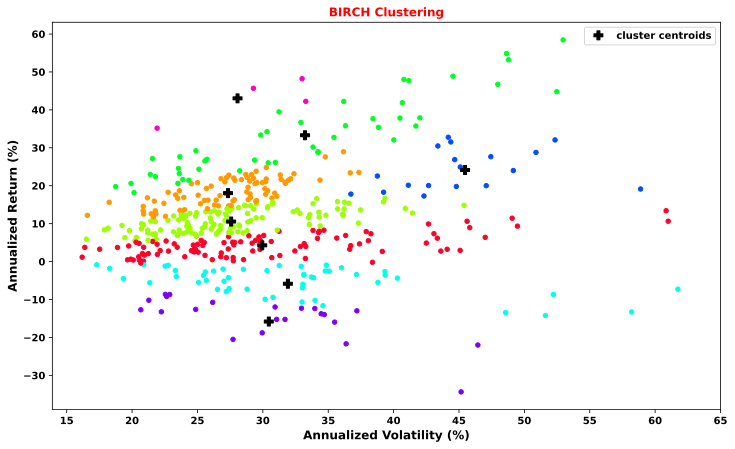

In [65]:
plot_clusters("BIRCH", summary, birch_clt_labels, birch_centroids)

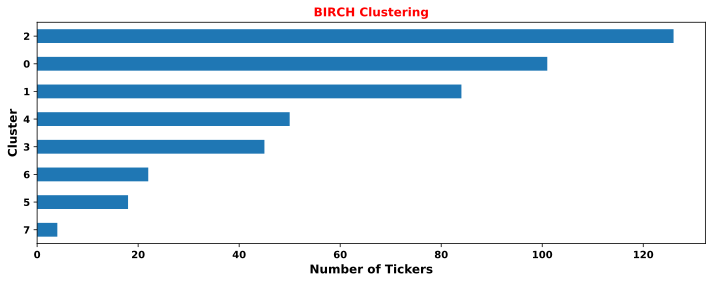

In [66]:
plot_clusters_count("BIRCH", birch_clt_labels)

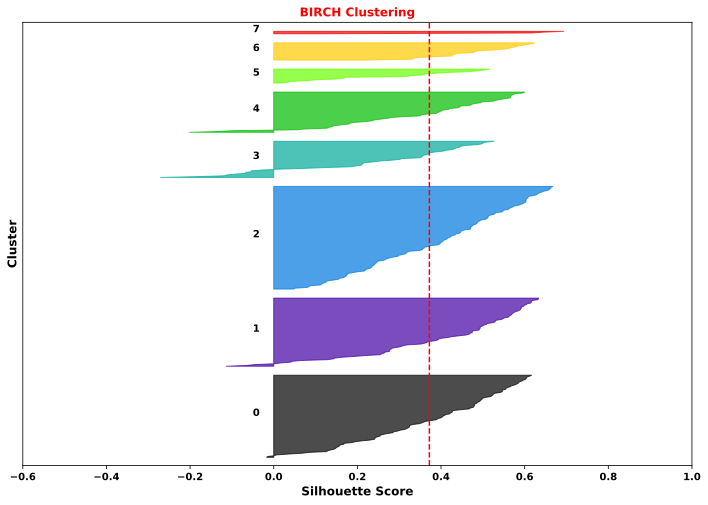

In [67]:
plot_clusters_silh("BIRCH", summary, birch_clt_labels)

## 10. Clustering Performance 
<a id="section-10"></a>

### Optimal Outcome :
- Maximize *between-cluster* variation
- Minimize *within-cluster* variation 

In [68]:
clt_labels_dict = {"K-Means" : kmeans_clt_labels , 
                   "Affinity Propagation" : affpg_clt_labels, 
                   "Mean Shift" : mnsft_clt_labels, 
                   "Hierarchical Agglomerative" : hagg_clt_labels , 
                   "DBSCAN" : dbscan_clt_labels, 
                   "Gaussian Mixture Models" : gmm_clt_labels, 
                   "BIRCH" : birch_clt_labels} 

### 10.1 Silhouette Score (>)
<a id="subsection-101"></a>

$$
S_i = \frac{b_i - a_i}{\max\{a_i, b_i\}}
$$

$\text{Where :}$
- $ a_i \text{ is the average distance from sample \(i\) to other points in the same cluster.} $
- $ b_i \text{ is the smallest average distance from sample \(i\) to points in a different cluster.} $

In [69]:
silh_scores = { }
for model_name in clt_labels_dict.keys( ) :
    if model_name != "BIRCH" :
        if model_name == "K-Means" or model_name == "Gaussian Mixture Models" :
            silh_scores[model_name] = metrics.silhouette_score(summary_scaled_no_outliers, clt_labels_dict[model_name])
        else :
            silh_scores[model_name] = metrics.silhouette_score(summary_scaled, clt_labels_dict[model_name])
    else :
        silh_scores[model_name] = metrics.silhouette_score(summary, clt_labels_dict[model_name], metric = "euclidean")
silhouette_scores = pd.DataFrame(silh_scores, index = ["Silhouette Score"]).T 

In [70]:
silhouette_scores.style\
                 .format("{:.4f}")\
                 .highlight_max(color = "lightgreen")\
                 .highlight_min(color = "lightcoral")

,Silhouette Score
K-Means,0.3896
Affinity Propagation,0.3859
Mean Shift,0.2548
Hierarchical Agglomerative,0.3681
DBSCAN,0.3276
Gaussian Mixture Models,0.3452
BIRCH,0.3722


### 10.2 Calinski-Harabasz Score (>) 
<a id="subsection-102"></a>

$$
CH = \frac{tr(B_k)}{tr(W_k)} \times \frac{N - k}{k - 1}
$$

$\text{Where :}$
- $ B_k \text{ is the between-cluster dispersion.} $
- $ W_k \text{ is the within-cluster dispersion.} $
- $ N \text{ is the total number of samples.} $
- $ k \text{ is the number of clusters.} $

In [71]:
ch_scores = { }
for model_name in clt_labels_dict.keys( ) :
    if model_name != "BIRCH" :
        if model_name == "K-Means" or model_name == "Gaussian Mixture Models" : 
            ch_scores[model_name] = metrics.calinski_harabasz_score(summary_scaled_no_outliers, clt_labels_dict[model_name])
        else :
            ch_scores[model_name] = metrics.calinski_harabasz_score(summary_scaled, clt_labels_dict[model_name])
    else :
        ch_scores[model_name] = metrics.calinski_harabasz_score(summary, clt_labels_dict[model_name])
    
ch_scores = pd.DataFrame(ch_scores, index = ["Calinski-Harabasz Score"]).T 

In [72]:
ch_scores.style\
         .format("{:.4f}")\
         .highlight_max(color = "lightgreen")\
         .highlight_min(color = "lightcoral")

,Calinski-Harabasz Score
K-Means,340.0779
Affinity Propagation,359.4972
Mean Shift,151.1183
Hierarchical Agglomerative,298.5453
DBSCAN,26.5165
Gaussian Mixture Models,313.7397
BIRCH,657.1181


### 10.3 Davies-Bouldin Score (<) 
<a id="subsection-103"></a>

$$
DB = \frac{1}{n}\sum_{i=1}^{n}\max_{i \neq j} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$

$\text{Where :}$
- $ n \text{ is the number of clusters.} $
- $ c_i \text{ is the centroid of cluster \(i\).} $
- $ \sigma_i \text{ is the average distance between points in cluster \(i\) and its centroid.} $
- $ d(c_i, c_j) \text{ is the distance between centroids \(c_i\) and \(c_j\).} $ 

In [73]:
db_scores = { }
for model_name in clt_labels_dict.keys( ) :
    if model_name != "BIRCH" :
        if model_name == "K-Means" or model_name == "Gaussian Mixture Models" : 
            db_scores[model_name] = metrics.davies_bouldin_score(summary_scaled_no_outliers, clt_labels_dict[model_name])
        else :
            db_scores[model_name] = metrics.davies_bouldin_score(summary_scaled, clt_labels_dict[model_name])
    else :
        db_scores[model_name] = metrics.davies_bouldin_score(summary, clt_labels_dict[model_name])
    
db_scores = pd.DataFrame(db_scores, index = ["Davies-Bouldin Score"]).T 

In [74]:
db_scores.style\
         .format("{:.4f}")\
         .highlight_max(color = "lightcoral")\
         .highlight_min(color = "lightgreen")

,Davies-Bouldin Score
K-Means,0.7898
Affinity Propagation,0.7167
Mean Shift,0.7101
Hierarchical Agglomerative,0.8094
DBSCAN,1.4658
Gaussian Mixture Models,0.7843
BIRCH,0.7854


## 11. Pairs Selection 
<a id="section-11"></a>

In [75]:
affpg_clt_counts = affpg_clt_df["Cluster"].value_counts( )
affpg_clt_labels = affpg_clt_df.copy( )

print (f"Clusters formed : {len(affpg_clt_counts)}") 
print (f"Pairs to evaluate : {(affpg_clt_counts * (affpg_clt_counts - 1)).sum( )}") 

Clusters formed : 25
Pairs to evaluate : 11428


In [76]:
pd.DataFrame(affpg_clt_counts)

,count
Cluster,
9,49
14,42
7,37
12,34
17,31
20,27
0,23
4,21
22,20


In [77]:
affpg_clt_labels 

,Cluster
Ticker,
A,9
AAL,23
AAPL,14
ABBV,24
ABT,4
...,...
XYL,9
YUM,20
ZBH,19


### 11.1 Augmented Engle-Granger Cointegration Test 
<a id="subsection-111"></a>

1. **Estimate the cointegrating regression**

    $ \Delta y_t = \alpha + \beta x_t + \varepsilon_t $

    $ \text{Where :}$
    - $ \Delta \text{ represents the differencing operator.} $
    - $ y_t \text{ and } x_t \text{ are the two time series.} $
    - $ \Delta y_t \text{ is the differenced time series $y_t$ at time t.} $
    - $ \alpha \text{ is a constant for the intercept term.} $ 
    - $ \beta \text{ is the coefficient on the variable \(x_t\).} $
    - $ \varepsilon_t \text{ is the error term at time t.} $ 

2. **Check for Stationarity of Residuals**
    
    $ \text{Use a unit root test (e.g., ADF test) on the residuals } \varepsilon_t. \text{The null hypothesis is that residuals have a unit root, indicating non-stationarity.} $

3. **Compute the Test Statistic**
    
    $ \text{EG} = \frac{\hat{\varepsilon}_t}{\text{SE}(\hat{\varepsilon}_t)} $ 
    
    $ \text{Where :}$
    - $ \hat{\varepsilon}_t \text{ is the estimated residual at time \(t\) from regressing one variable on the other.} $
    - $ \text{SE}(\hat{\varepsilon}_t) \text{ is the standard error of the estimated residual.} $

4. **Compare to the Critical Value** 
   - $ \text{If the test statistic is greater than the critical value, reject the null hypothesis of no cointegration. Residuals are therefore stationary.} $

In [78]:
def EG_clt_pairs(clt_close_df, significance = 0.01) : 
    """
    Arguments :
    - clt_close_df : DataFrame of closing prices of tickers in the cluster 
    - significance : float representing the significance level -> 0.01 or 0.05 or 0.1   

    Returns :
    - clt_pairs_df : DataFrame displaying the cointegrated pairs' tickers, industries, and correlation coefficients 
    
    Function :
    - Conducts the Engle-Granger cointegration test between all possible pairs in the cluster 
    - Selects pairs with cointegration p-value lower than the specified significance level 
    - Computes the correlation between tickers' closing prices in each cointegrated pair 
    - Maps to each pair's ticker its industry
    """
    n_tickers = clt_close_df.shape[1]
    tickers = clt_close_df.columns
    
    clt_pairs = [  ]
    # pairs_pvals = [  ]
    pairs_corr = [  ]
    for i in range(n_tickers - 1) :
        
        for j in range(i + 1, n_tickers) :
            ticker1_close = clt_close_df[ tickers[i] ].values
            ticker2_close = clt_close_df[ tickers[j] ].values
            
            result = stattools.coint(ticker1_close, ticker2_close)
            pvalue = result[1]
            
            if pvalue < significance :
                clt_pairs.append((tickers[i], tickers[j]))
                # pairs_pvals.append(pvalue)
                pairs_corr.append(close[tickers[i]].corr(close[tickers[j]]))
    
    clt_pairs_df = pd.DataFrame(clt_pairs, columns = ["Ticker1", "Ticker2"])
    # clt_pairs_df["Cointegration P_Value"] = pairs_pvals
    clt_pairs_df["Correlation"] = pairs_corr
    
    industry_mapper = dict(zip(sp500_constituents["Symbol"], sp500_constituents["GICS Sector"]))
    clt_pairs_df["Ticker1 Industry"] = clt_pairs_df["Ticker1"].map(industry_mapper)
    clt_pairs_df["Ticker2 Industry"] = clt_pairs_df["Ticker2"].map(industry_mapper)
    
    clt_pairs_df = clt_pairs_df[["Ticker1", "Ticker1 Industry", "Ticker2", "Ticker2 Industry", "Correlation"]]
    return clt_pairs_df 

In [79]:
def all_pairs(clt_labels_df, coint_func) :
    """
    Arguments :
    - clt_labels_df : DataFrame displaying the cluster label of each ticker 
    - coint_func : function for extracting cointegrated pairs in each cluster 

    Returns :
    - all_pairs_df : DataFrame displaying all cointegrated pairs' tickers, industries, and correlation coefficients
    
    Function :
    - Extracts cointegrated pairs in every cluster 
    - Maps to each pair its cluster label 
    - Plots a bar chart displaying the number of pairs found in each cluster 
    - Plots a pie chart displaying the industry composition of these pairs (in %)
    """
    dfs_to_concat = [  ]
    for clt in clt_labels_df["Cluster"].unique( ) :
        clt_tickers = clt_labels_df.loc[clt_labels_df["Cluster"] == clt].index 
        clt_pairs = coint_func(close[clt_tickers])
        dfs_to_concat.append(clt_pairs)    
        
    all_pairs_df = pd.concat(objs = dfs_to_concat, axis = 0)
    all_pairs_df = all_pairs_df.reset_index(drop = True) 
    
    cluster_mapper = clt_labels_df["Cluster"].to_dict( )
    all_pairs_df["Cluster"] = all_pairs_df["Ticker1"].map(cluster_mapper)
    all_pairs_df.set_index("Cluster", inplace = True)
    
    stocks_in_pairs = pd.concat(objs = [all_pairs_df["Ticker1"], all_pairs_df["Ticker2"]]).unique( )
    print (f"Number of pairs found : {len(all_pairs_df)}")
    print (f"In those pairs, there are {len(stocks_in_pairs)} unique tickers") 
    
    n_clusters = all_pairs_df.index.nunique( )
    clt_pairs_count = all_pairs_df.index.value_counts(ascending = True)
        
    clt_pairs_count.plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
    plt.xlabel("Number of Pairs", fontsize = 12)
    plt.ylabel("Cluster", fontsize = 12)
    plt.show( )
    
    all_industries = pd.concat([all_pairs_df["Ticker1 Industry"], all_pairs_df["Ticker2 Industry"]]).unique( )
    industry_count = pd.Series(0, index = all_industries)

    industry_count = industry_count.add(all_pairs_df["Ticker1 Industry"].value_counts( ), fill_value = 0)
    industry_count = industry_count.add(all_pairs_df["Ticker2 Industry"].value_counts( ), fill_value = 0)
    industry_count = industry_count.mask(all_pairs_df["Ticker1 Industry"] == all_pairs_df["Ticker2 Industry"], 
                                         industry_count - 1)
    
    colors = sns.color_palette("Set3")
    plt.pie(industry_count, labels = industry_count.index, colors = colors, autopct = "%.f%%", radius = 1.4)
    plt.show( )
    
    return all_pairs_df

Number of pairs found : 98
In those pairs, there are 125 unique tickers


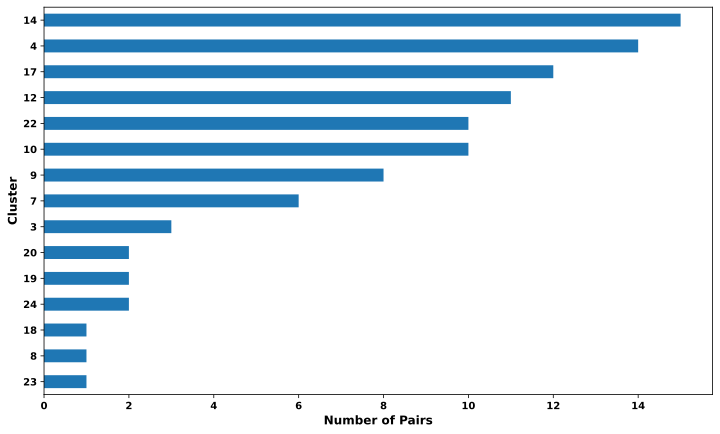

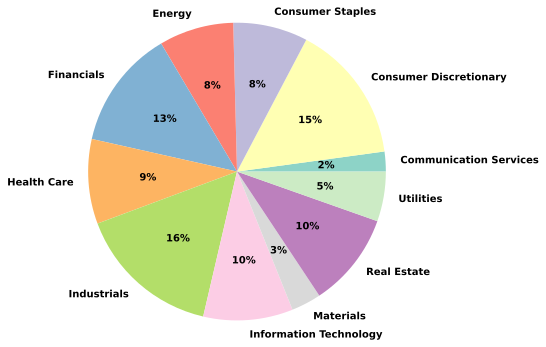

In [80]:
EG_pairs = all_pairs(affpg_clt_labels, EG_clt_pairs)

In [81]:
EG_pairs.round(4) 

,Ticker1,Ticker1 Industry,Ticker2,Ticker2 Industry,Correlation
Cluster,,,,,
9,BAC,Financials,FRT,Real Estate,0.9029
9,CTVA,Materials,GRMN,Consumer Discretionary,-0.8189
9,CVS,Health Care,FI,Financials,-0.7519
9,EMR,Industrials,EQIX,Real Estate,0.6152
9,HSIC,Health Care,RTX,Industrials,0.7616
...,...,...,...,...,...
20,DGX,Health Care,PM,Consumer Staples,0.4102
20,KO,Consumer Staples,NI,Utilities,0.8825
3,BAX,Health Care,HAS,Consumer Discretionary,0.9522


In [82]:
def tickers_in_pairs(all_pairs_df, clt_labels_df) :
    """
    Arguments :
    - all_pairs_df : DataFrame displaying all cointegrated pairs' tickers, industries, and correlation coefficients
    - clt_labels_df : DataFrame displaying the cluster label of each ticker 

    Returns :
    - in_pairs_summary_df : DataFrame displaying the cluster, annualized return, annualized volatility, and annualized sharpe 
                            of each unique ticker in the extracted pairs 
    
    Function :
    - Extracts unique tickers 
    - Retrieves the standardized annualized return, annualized volatility, and annualized sharpe of each ticker 
    - Maps to each ticker its cluster label 
    """
    stocks_in_pairs = pd.concat(objs = [all_pairs_df["Ticker1"], all_pairs_df["Ticker2"]], axis = 0).unique( )
    labels_df = clt_labels_df.loc[stocks_in_pairs].sort_index( ) 
    risk_return_df = summary_scaled.loc[stocks_in_pairs].sort_index( ) 
    
    in_pairs_summary_df = pd.concat(objs = [labels_df, risk_return_df], axis = 1)
    return in_pairs_summary_df  

In [83]:
in_EG_pairs_summary = tickers_in_pairs(EG_pairs, affpg_clt_labels)

In [84]:
in_EG_pairs_summary.round(4)

,Cluster,Annual Return,Annual Volatility,Annual Sharpe
Ticker,,,,
ADI,14,0.2892,0.0566,0.2939
ADSK,22,-0.8453,1.0427,-0.9243
AEP,4,-0.7337,-1.1604,-0.7564
AMAT,8,1.5242,1.6594,0.8631
AMP,12,1.2357,-0.0676,1.3891
...,...,...,...,...
WST,10,0.1481,0.3599,0.0629
WYNN,23,-0.6034,1.8691,-0.7472
ZBH,19,-1.1150,-0.5504,-1.2767


### 11.2 Augmented Dickey Fuller Cointegration Test
<a id="subsection-112"></a>

1. **Estimate the cointegrating regression**

    $ \Delta y_t = \rho y_{t-1} + \gamma t + \alpha + \beta_1 \Delta y_{t-1} + \beta_2 \Delta y_{t-2} + \ldots + \beta_p \Delta y_{t-p} + \varepsilon_t $

    $\text{Where :}$
    - $ \Delta \text{ represents the differencing operator.} $
    - $ y_t \text{ is the level of the time series at time \(t\)}. $
    - $ \Delta y_t \text{ is the differenced time series at time t.} $
    - $ y_{t-1} \text{ is the lagged level of the time series at time t-1.} $
    - $ \Delta y_{t-1} \text{ is the differenced lagged level of the time series at time t-1.} $
    - $ \rho \text{ is the lag order.} $
    - $ \gamma \text{ is the coefficient on the trend term.} $
    - $ \alpha \text{ is a constant for the intercept term associated with } \Delta y_{t - 1}. $
    - $ \beta_1, \beta_2, \ldots, \beta_p \text{ are coefficients on the lagged differences of the time series up to order p.} $
    - $ \varepsilon_t \text{ is the error term at time t.} $

2. **Compute the Test Statistic**
    
    $ \text{ADF} = \frac{\hat{\alpha}_t}{\text{SE}(\hat{\alpha}_t)} $ 
    
    $ \text{Where :}$
    - $ \hat{\alpha}_t \text{ is the estimated intercept term of the lagged first difference in the ADF regression equation.} $
    - $ \text{SE}(\hat{\varepsilon}_t) \text{ is the standard error of the estimated intercept term.} $

3. **Compare to the Critical Value** 
   - $ \text{If the test statistic is greater than the critical value, reject the null hypothesis of no cointegration. Residuals are therefore stationary.} $

In [85]:
def ADF_clt_pairs(clt_close_df, significance = 0.01) : 
    """
    Arguments :
    - clt_close_df : DataFrame of closing prices of tickers in the cluster 
    - significance : float representing the significance level -> 0.01 or 0.05 or 0.1   

    Returns :
    - clt_pairs_df : DataFrame displaying the cointegrated pairs' tickers, industries, and correlation coefficients  
    
    Function :
    - Conducts the Augmented Dickey Fuller cointegration test between all possible pairs in the cluster 
    - Selects pairs with cointegration p-value lower than the specified significance level 
    - Computes the correlation between tickers' closing prices in each cointegrated pair 
    - Maps to each pair's ticker its industry
    """
    n_tickers = clt_close_df.shape[1]
    tickers = clt_close_df.columns
    
    clt_pairs = [  ]
    # pairs_pvals = [  ]
    pairs_corr = [  ]
    for i in range(n_tickers - 1) :
        
        for j in range(i + 1, n_tickers) :
            ticker1_close = clt_close_df[ tickers[i] ].values
            ticker2_close = clt_close_df[ tickers[j] ].values
            
            result = linear_model.OLS(ticker1_close, ticker2_close).fit( )
            c_t = stattools.adfuller(result.resid)
            t_stat = c_t[0]
            pvalue = c_t[1]
            crit_vals = c_t[4]
            
            cv_index = {0.01 : "1%", 0.05 : "5%", 0.10 : "10%"}
            if t_stat <= crit_vals[cv_index[significance]] and pvalue <= significance :
                clt_pairs.append((tickers[i], tickers[j]))
                # pairs_pvals.append(pvalue)
                pairs_corr.append(close[tickers[i]].corr(close[tickers[j]]))
    
    clt_pairs_df = pd.DataFrame(clt_pairs, columns = ["Ticker1", "Ticker2"])
    # clt_pairs_df["Cointegration P_Value"] = pairs_pvals
    clt_pairs_df["Correlation"] = pairs_corr 
    
    industry_mapper = dict(zip(sp500_constituents["Symbol"], sp500_constituents["GICS Sector"]))
    clt_pairs_df["Ticker1 Industry"] = clt_pairs_df["Ticker1"].map(industry_mapper)
    clt_pairs_df["Ticker2 Industry"] = clt_pairs_df["Ticker2"].map(industry_mapper)
    
    clt_pairs_df = clt_pairs_df[["Ticker1", "Ticker1 Industry", "Ticker2", "Ticker2 Industry", "Correlation"]]
    return clt_pairs_df 

Number of pairs found : 137
In those pairs, there are 170 unique tickers


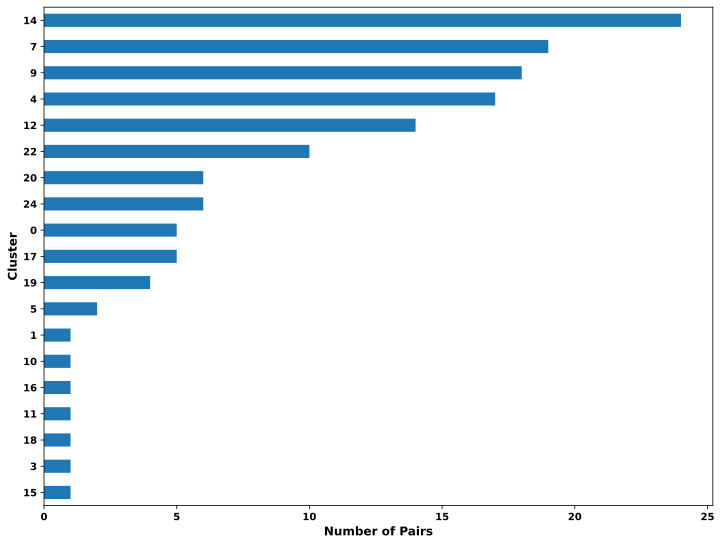

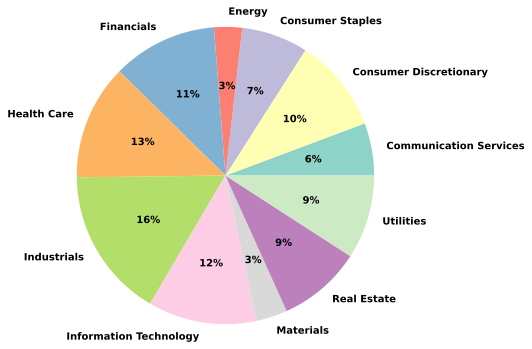

In [86]:
ADF_pairs = all_pairs(affpg_clt_labels, ADF_clt_pairs)

In [87]:
ADF_pairs.round(4) 

,Ticker1,Ticker1 Industry,Ticker2,Ticker2 Industry,Correlation
Cluster,,,,,
9,ALLE,Industrials,BLK,Financials,0.8983
9,BK,Financials,DOV,Industrials,0.8822
9,CINF,Financials,HSIC,Health Care,0.6631
9,CSCO,Information Technology,DOV,Industrials,0.8519
9,CSCO,Information Technology,EQIX,Real Estate,0.7409
...,...,...,...,...,...
20,KO,Consumer Staples,SO,Utilities,0.8260
20,PEG,Utilities,PM,Consumer Staples,0.5402
3,LUV,Industrials,TFX,Health Care,0.9178


In [88]:
in_ADF_pairs_summary = tickers_in_pairs(ADF_pairs, affpg_clt_labels)

In [89]:
in_ADF_pairs_summary.round(4)

,Cluster,Annual Return,Annual Volatility,Annual Sharpe
Ticker,,,,
ABBV,24,0.2918,-1.1181,0.8496
ACN,17,0.1852,-0.5281,0.3846
ADI,14,0.2892,0.0566,0.2939
ADSK,22,-0.8453,1.0427,-0.9243
AEE,4,-0.8624,-1.1353,-0.9611
...,...,...,...,...
WTW,9,-0.2486,-0.6620,-0.1359
WY,7,-0.4389,-0.2563,-0.4513
XEL,4,-0.8585,-1.1409,-0.9551


### 11.3 Pairs Selection : Johansen Cointegration Test 
<a id="subsection-113"></a>

1. **Estimate the Vector Autoregression Model**

    $ \Delta y_t = \Gamma_1 \Delta y_{t-1} + \Gamma_2 \Delta y_{t-2} + ... + \Gamma_{p} \Delta y_{t-p} + \varepsilon_t $

    $\text{Where :}$
    - $ \Delta \text{ represents the differencing operator.} $
    - $ y_t \text{ is the level ${k \times 1}$ vector of time series variables at time \(t\)}. $
    - $ \Delta y_t \text{ is the differenced  ${k \times 1}$ vector of time series variables at time t.} $
    - $ y_{t-1} \text{ is the lagged level ${k \times 1}$ vector of time series variables at time t-1.} $
    - $ \Delta y_{t-1} \text{ is the differenced  lagged level ${k \times 1}$ vector of time series variables at time t-1.} $
    - $ \rho \text{ is the lag order.} $
    - $ \Gamma_1, \Gamma_2, ..., \Gamma_{p} \text{ are ${k \times k}$ matrices of coefficients for the first-order differences up to lag p.} $
    - $ \varepsilon_t \text{ is the ${k \times 1}$ vector of residuals at time t.} $

2. **Eigenvalue Decomposition of $\Gamma$** 

    $ \Gamma = \Pi \times \Lambda \times \Pi^{-1} $
    
    $\text{Where :}$
    - $ \Gamma \text{ is the ${k \times (k \times p)}$ matrix obtained by combining coefficient matrices $\Gamma_1, \Gamma_2, ..., \Gamma_{p}$.} $
    - $ \Pi \text{ is the ${k \times r}$ matrix of cointegrating eigenvectors.} $
    - $ \Lambda \text{ is the ${(k \times p) \times (k \times p)}$ diagonal matrix of eigenvalues.} $
    - $ \Pi^{-1} \text{ is the inverse matrix of $\Pi$.} $

3. **Compute the Test Statistics**

    $ \text{Trace} = -T \sum_{i=r+1}^{k} \ln(1 - \hat{\lambda}_i) $
    
    $\text{Max-Eigen} = -T \ln(1 - \lambda_{r+1}) $

    $\text{Where :}$
    - $ T \text{ is the number of observations.} $
    - $ k \text{ is the number of time series variables.} $
    - $ r \text{ is the number of cointegrating eigenvectors (rank of cointegration).} $
    - $ \lambda_i \text{ are the estimated eigenvalues.} $ 

4. **Compare to the Critical Values** 
   - $ \text{If both test statistics are greater than their critical values, reject the null hypothesis of no cointegration. Residuals are therefore stationary.} $

In [90]:
def JH_clt_pairs(clt_close_df, significance = 0.01) : 
    """
    Arguments :
    - clt_close_df : DataFrame of closing prices of tickers in the cluster 
    - significance : float representing the significance level -> 0.01 or 0.05 or 0.1   

    Returns :
    - clt_pairs_df : DataFrame displaying the cointegrated pairs' tickers, industries, and correlation coefficients  
    
    Function :
    - Conducts the Johansen cointegration test between all possible pairs in the cluster 
    - Selects pairs with both trace statistics higher than their respective critical values at the specified significance level 
    - Computes the correlation between tickers' closing prices in each cointegrated pair 
    - Maps to each pair's ticker its industry 
    """
    n_tickers = clt_close_df.shape[1]
    tickers = clt_close_df.columns
    
    clt_pairs = [  ]
    pairs_corr = [  ]
    for i in range(n_tickers - 1) :
        
        for j in range(i + 1, n_tickers) :
            pair_close = clt_close_df[ [tickers[i] , tickers[j]] ].copy( )
            
            var = var_model.VAR(pair_close)
            lags = var.select_order(trend = "c")
            order = lags.selected_orders["aic"]
            
            result = vecm.coint_johansen(pair_close, det_order = 0, k_ar_diff = order)
            
            cv_index = {0.01 : 0, 0.05 : 1, 0.10 : 2}
            trace_stat = result.lr1
            trace_cv = result.cvt[:, cv_index[significance]]
            max_eigen_stat = result.lr2
            max_eigen_cv = result.cvm[:, 0]
            
            if (trace_stat[0] > trace_cv[0]) and (trace_stat[1] > trace_cv[1]) and (max_eigen_stat[0] > max_eigen_cv[0]) and (max_eigen_stat[1] > max_eigen_cv[1]) : 
                clt_pairs.append((tickers[i], tickers[j]))
                pairs_corr.append(close[tickers[i]].corr(close[tickers[j]]))
    
    clt_pairs_df = pd.DataFrame(clt_pairs, columns = ["Ticker1", "Ticker2"])
    clt_pairs_df["Correlation"] = pairs_corr 
    
    industry_mapper = dict(zip(sp500_constituents["Symbol"], sp500_constituents["GICS Sector"]))
    clt_pairs_df["Ticker1 Industry"] = clt_pairs_df["Ticker1"].map(industry_mapper)
    clt_pairs_df["Ticker2 Industry"] = clt_pairs_df["Ticker2"].map(industry_mapper)
    
    clt_pairs_df = clt_pairs_df[["Ticker1", "Ticker1 Industry", "Ticker2", "Ticker2 Industry", "Correlation"]]
    return clt_pairs_df 

Number of pairs found : 771
In those pairs, there are 278 unique tickers


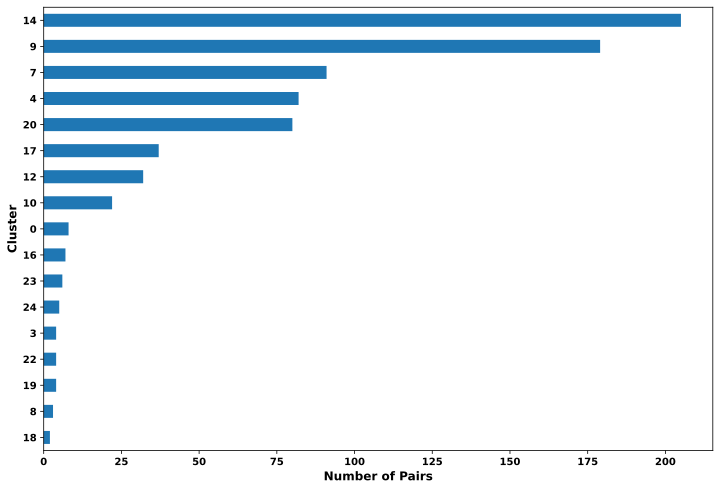

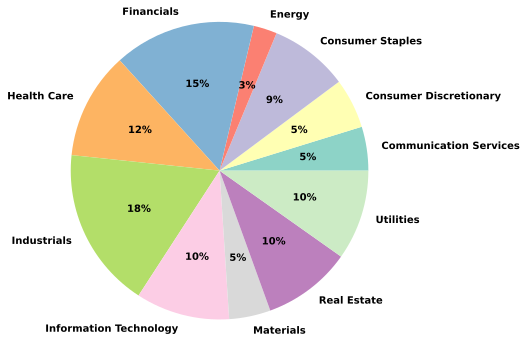

In [91]:
JH_pairs = all_pairs(affpg_clt_labels, JH_clt_pairs)

In [92]:
JH_pairs.round(4)

,Ticker1,Ticker1 Industry,Ticker2,Ticker2 Industry,Correlation
Cluster,,,,,
9,A,Health Care,EIX,Utilities,-0.2194
9,A,Health Care,TMO,Health Care,0.5814
9,AIZ,Financials,CSX,Industrials,0.4146
9,AIZ,Financials,EMR,Industrials,0.2501
9,AIZ,Financials,J,Industrials,0.6538
...,...,...,...,...,...
16,CTRA,Energy,MU,Information Technology,-0.6025
16,CTRA,Energy,STX,Information Technology,-0.4113
16,DXCM,Health Care,MGM,Consumer Discretionary,0.6964


### 11.4 Top Pairs : Strongly Cointegrated and Highly Correlated
<a id="subsection-114"></a>

In [93]:
EG_pairs["Pair"] = EG_pairs["Ticker1"] + "-" + EG_pairs["Ticker2"]
ADF_pairs["Pair"] = ADF_pairs["Ticker1"] + "-" + ADF_pairs["Ticker2"]
JH_pairs["Pair"] = JH_pairs["Ticker1"] + "-" + JH_pairs["Ticker2"]

In [94]:
top_pairs = JH_pairs.loc[(JH_pairs["Pair"].isin(ADF_pairs["Pair"])) & (JH_pairs["Pair"].isin(EG_pairs["Pair"]))
                         & (JH_pairs["Correlation"] > 0.85)]
top_pairs.drop(columns = "Pair", inplace = True)

In [95]:
top_pairs 

,Ticker1,Ticker1 Industry,Ticker2,Ticker2 Industry,Correlation
Cluster,,,,,
14,AVY,Materials,GS,Financials,0.855664
14,CBRE,Real Estate,IQV,Health Care,0.899160
24,NOC,Industrials,UNH,Health Care,0.901633
24,NOC,Industrials,WRB,Financials,0.917456
4,ETR,Utilities,WEC,Utilities,0.900858
4,EVRG,Utilities,O,Real Estate,0.915021
18,APA,Energy,MRO,Energy,0.982449
20,KO,Consumer Staples,NI,Utilities,0.882544


In [96]:
in_top_pairs_summary = tickers_in_pairs(top_pairs, affpg_clt_labels)

In [97]:
in_top_pairs_summary.round(4) 

,Cluster,Annual Return,Annual Volatility,Annual Sharpe
Ticker,,,,
APA,18,2.6303,2.7798,1.2448
AVY,14,0.1380,-0.3418,0.2554
CBRE,14,0.5410,0.0369,0.5728
ETR,4,-0.6072,-0.9582,-0.5812
EVRG,4,-0.8223,-1.1151,-0.8979
GS,14,0.4215,-0.4305,0.6381
IQV,14,0.1497,-0.1345,0.2005
KO,20,-0.5417,-1.6687,-0.3337
MRO,18,3.4072,2.3069,1.9374


### 11.5 Pairs Visualization 
<a id="subsection-115"></a>

In [98]:
def visualize_top_pairs(top_pairs_df, in_pairs_summary_df) :
    """
    Arguments :
    - top_pairs_df : DataFrame displaying top pairs' tickers, industries, and correlation coefficients
    - in_pairs_summary_df : DataFrame displaying the cluster, annualized return, annualized volatility, and annualized sharpe 
                            of each ticker in top pairs 

    Returns :
    - None 
    
    Function :
    - Draws a t-SNE plot of pair tickers 
    - Connects each pair's tickers with a grey line 
    - Annotates all tickers 
    """    
    summary_tsne = manifold.TSNE(perplexity = 3, learning_rate = 50).fit_transform(in_pairs_summary_df) 
    
    plt.figure(1, facecolor = "white", figsize = (12, 7))
    plt.clf( )
    plt.axis("off")
    
    for pair in list(zip(top_pairs_df["Ticker1"], top_pairs_df["Ticker2"])) : 
        ticker1 = pair[0]
        loc1 = in_pairs_summary_df.index.get_loc(pair[0])
        x1, y1 = summary_tsne[loc1 , :]

        ticker2 = pair[0]
        loc2 = in_pairs_summary_df.index.get_loc(pair[1])
        x2, y2 = summary_tsne[loc2 , :]
      
        plt.plot([x1, x2], [y1, y2], "k-", alpha = 0.3)
    
    plt.scatter(summary_tsne[: , 0], summary_tsne[: , 1], s = 220, alpha = 0.9, 
                c = in_pairs_summary_df["Cluster"].values, cmap = cm.Paired)
    plt.title("Cointegrated Pairs", c = "red") 

    for x, y, name in zip(summary_tsne[: , 0], summary_tsne[: , 1], in_pairs_summary_df.index) :
        plt.annotate(name, (x, y), textcoords = "offset points", xytext = (0, 10), fontsize = 8, ha = "center")

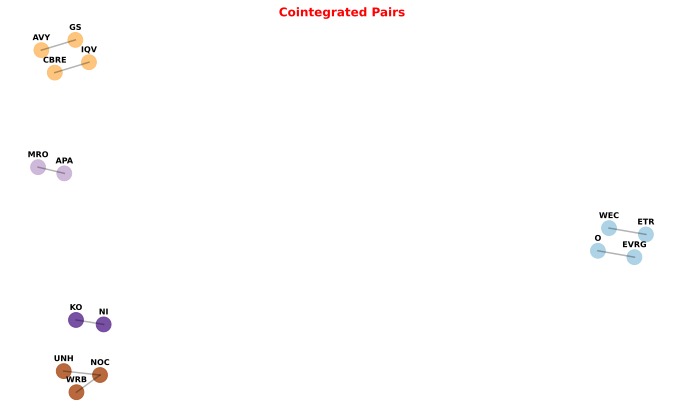

In [99]:
visualize_top_pairs(top_pairs, in_top_pairs_summary)

In [100]:
def pair_movements(ticker1, ticker2) :
    """
    Arguments :
    - ticker1 : str for the first ticker in the pair
    - ticker2 : str for the second ticker in the pair 
    
    Returns :
    - None 
    
    Function :
    - Draws line plots of normalized closing prices for each ticker 
    """
    norm_close_pair = close[[ticker1, ticker2]].div(close[[ticker1, ticker2]].iloc[0]).mul(100)
    norm_close_pair.plot(figsize = (12, 5), fontsize = 10)
    
    plt.xlabel(xlabel = "")
    plt.ylabel(ylabel = "Normalized Close ($)", fontsize = 12)
    plt.show( )

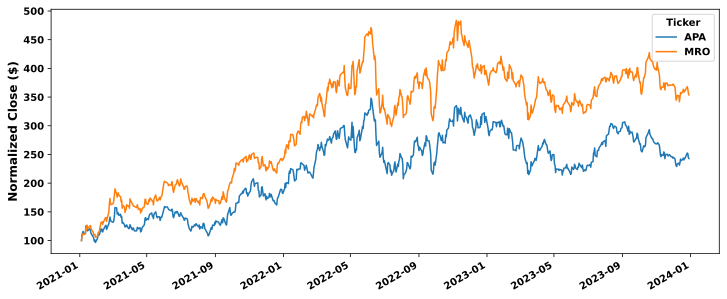

In [101]:
pair_movements("APA", "MRO")

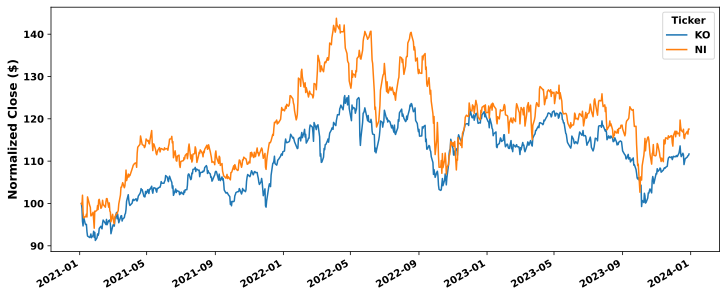

In [102]:
pair_movements("KO", "NI")

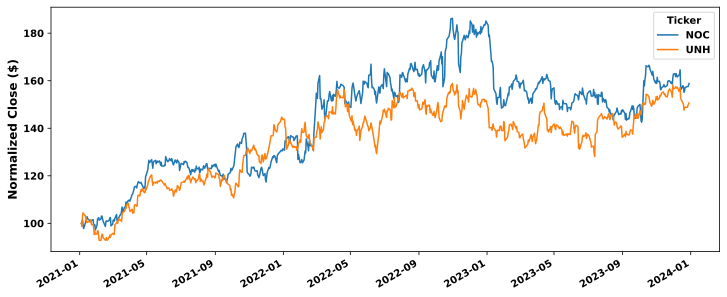

In [103]:
pair_movements("NOC", "UNH")

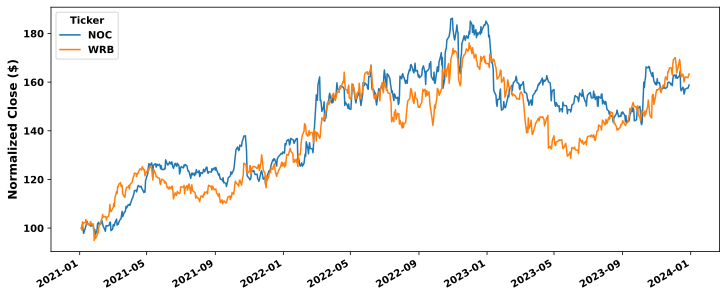

In [104]:
pair_movements("NOC", "WRB")

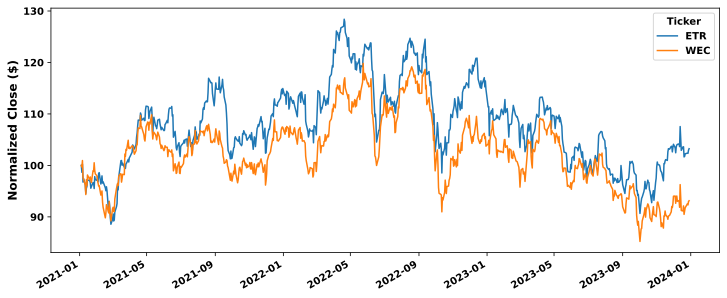

In [105]:
pair_movements("ETR", "WEC")

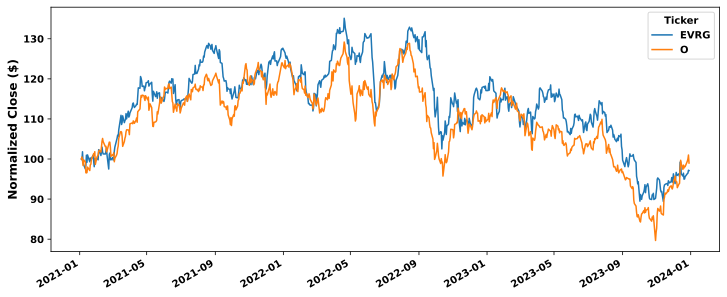

In [106]:
pair_movements("EVRG", "O")

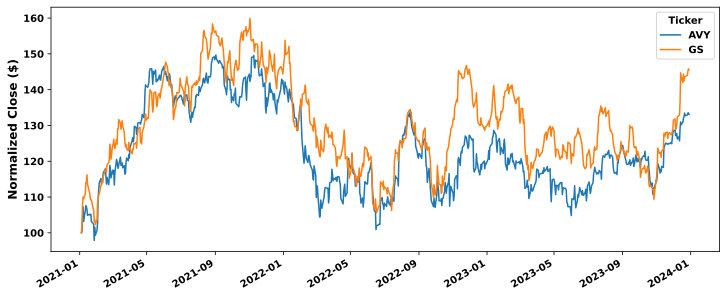

In [107]:
pair_movements("AVY", "GS")

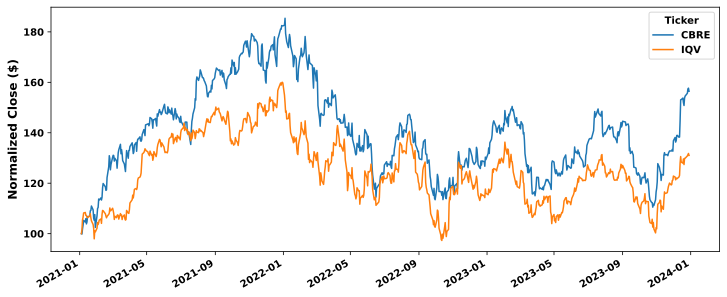

In [108]:
pair_movements("CBRE", "IQV")

## 12. Pairs Trading
<a id="section-12"></a>

### Spread and Bollinger Bands
<a id="subsection-121"></a>

In [109]:
in_pairs_tickers = in_top_pairs_summary.index.tolist( )
in_pairs_close = yf.download(tickers = in_pairs_tickers, start = start_date, end = "2024-05-01")["Close"]

[*********************100%%**********************]  15 of 15 completed


In [110]:
def plot_bollinger_bands(pair, window = 10) :
    """
    Arguments :
    - pair : tuple containing the tickers of a pair 
    - window : int representing the rolling window for computing the Bollinger Bands 
    
    Returns :
    - None 
    
    Function :
    - Plots the spread between the closing prices of the pair's tickers  
    - Plots the middle bollinger band, which is the moving average of the spread 
    - Plots the upper bollinger band, which is 2 standard deviations above the middle band 
    - Plots the lower bollinger band, which is 2 standard deviations below the middle band  
    """
    ticker1, ticker2 = pair 
    pair_close = in_pairs_close[[ticker1, ticker2]].copy( )
    
    pair_close["Hedge Ratio"] = pair_close[ticker1].div(pair_close[ticker2]).rolling(window).mean( ) 
    pair_close["Pair Spread"] = pair_close[ticker1].sub(pair_close[ticker2] * pair_close["Hedge Ratio"])
    
    z_score = norm.ppf((1 + 0.9) / 2)
    pair_close["Middle Band"] = pair_close["Pair Spread"].rolling(window).mean( ) 
    pair_close["Lower Band"] = pair_close["Middle Band"] - pair_close["Pair Spread"].rolling(window).std( ) * z_score  
    pair_close["Upper Band"]  =  pair_close["Middle Band"] + pair_close["Pair Spread"].rolling(window).std( ) * z_score
    
    fig , ax = plt.subplots(figsize = (12 , 7), sharex = False, sharey = False, nrows = 1, ncols = 1)
    colors = ["black", "tab:blue", "tab:red", "tab:green"]
    
    # for i, year in enumerate(np.unique(close.index.year)) :
    for j, indicator in enumerate(["Pair Spread", "Middle Band", "Lower Band", "Upper Band"]) :
            
        ax.plot(pair_close.loc["2024", indicator], c = colors[j], label = indicator)
        ax.set_xlabel("")
        ax.legend( )
    
    plt.show( )

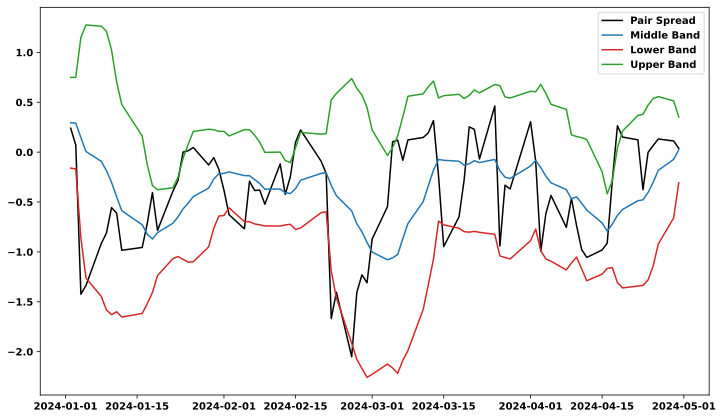

In [111]:
plot_bollinger_bands(("APA", "MRO"))

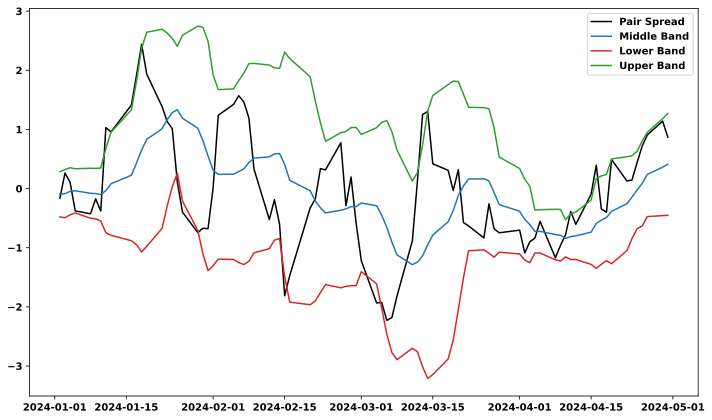

In [112]:
plot_bollinger_bands(("KO", "NI"))

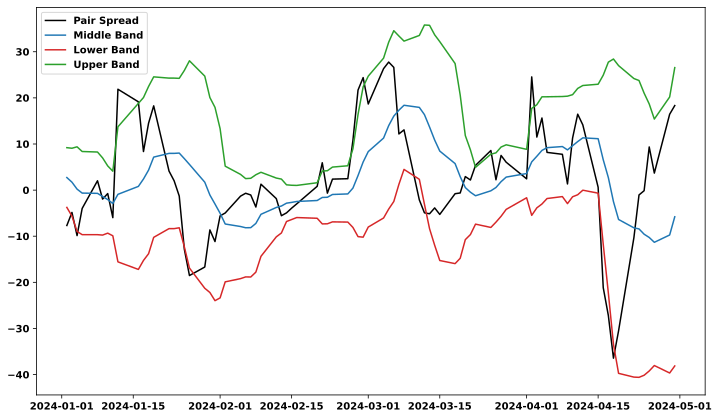

In [113]:
plot_bollinger_bands(("NOC", "UNH"))

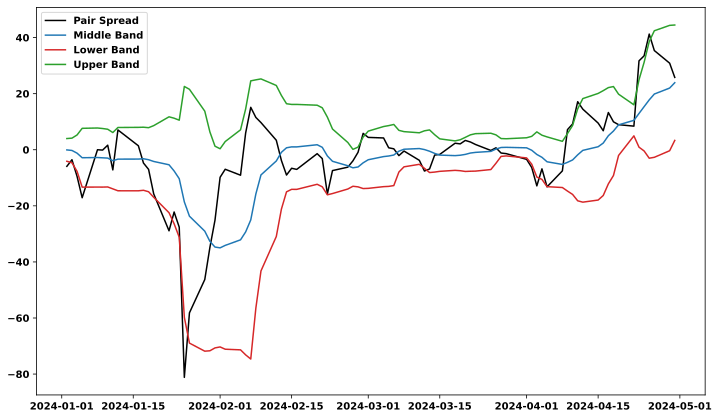

In [114]:
plot_bollinger_bands(("NOC", "WRB"))

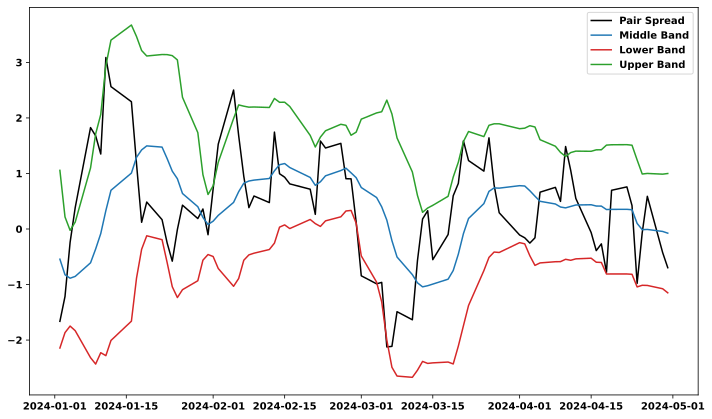

In [115]:
plot_bollinger_bands(("ETR", "WEC"))

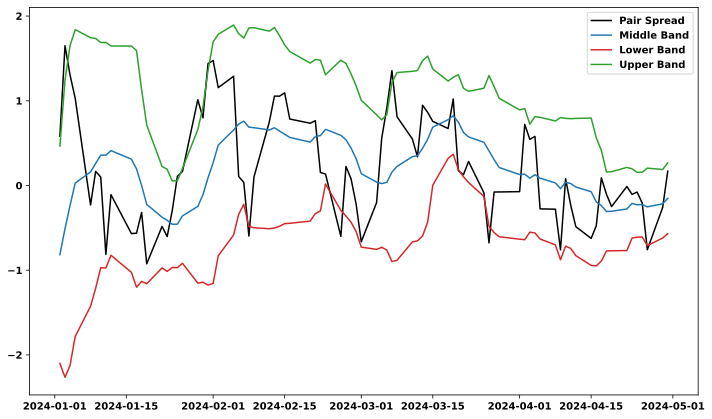

In [116]:
plot_bollinger_bands(("EVRG", "O"))

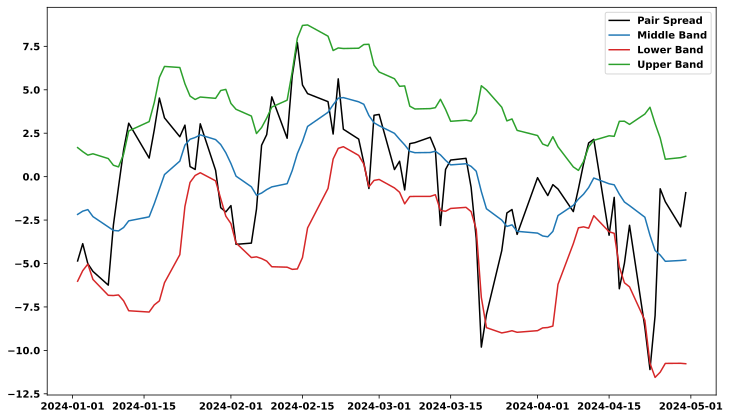

In [117]:
plot_bollinger_bands(("AVY", "GS"))

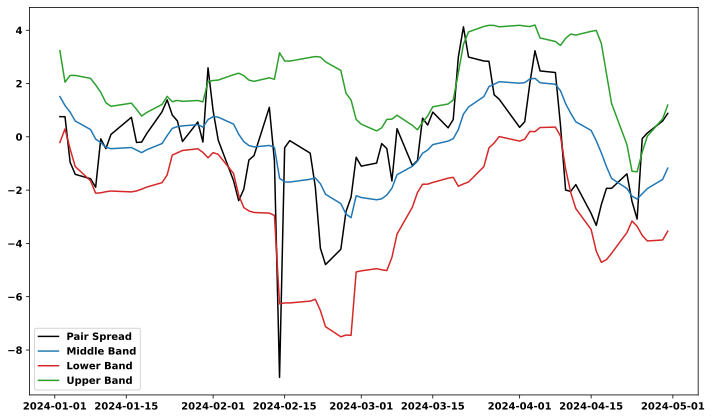

In [118]:
plot_bollinger_bands(("CBRE", "IQV"))

## Thank You for Your Attention. =))

# Author 
[Khai Lap Vuong](https://www.linkedin.com/in/khai-lap-vuong/)